### Johns Hopkins Covid-19 Data and R, Part II, data.table functions and graphics, plus R-Naught.

*Summary: This blog is part II of a series showcasing management and analytics of the daily U.S. Covid-19 case/death data published by the [Center for Systems Science and Engineering at Johns Hopkins University](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series#start-of-content). Whereas [part I](https://www.datasciencecentral.com/profiles/blogs/johns-hopkins-covid-19-data-and-r-part-i-data-table-handling) focused on data management, part II highlights management while conducting a deeper dive in analytics. The technology deployed is R driven by its splendid data.table package. Analysts with several months of R experience should benefit from the notebook below.*

Deaths from covid-19 surpassed the grim total of 100,000 last week, with the count now exceeding 105,000 and still growing at almost 1,000 per day. Meanwhile, the number of cases in the U.S. stands at 1,800,000+, with more than 20,000 added daily. While a portion of these new case counts is undoubtedly the product of enhanced testing, the numbers are nonetheless staggering. A 150,000 death total by Labor Day with 200,000 by year's end are conservative estimates. "This is just a flu" -- Not.

The current day's CSSE data are available for download at 10 CDT daily.  There are case and death files, each of which has a similar structure. The granularity is geography such as county within states. A new column is added each day holding the cumulative counts for each geography. The data munging revolves on pivoting or melting the data into R data.tables and computing daily counts as differences of successive cumulative records. 

A problem with the data, noted on the website, is that "The time series tables are subject to be updated if inaccuracies are identified in our historical data. The daily reports will not be adjusted in these instances to maintain a record of raw data." I show examples of the problems below. One issue often encountered is that some states at times don't update the counts. This will manifest as cumulative figures being identical on successive days. Another common anomaly is that some counts are initially attributed to an "unassigned" geography and later updated to known locations. The cumulative "unassigned" category thus decreases, resulting in negative daily counts.  I manage around the data problems by generally avoiding counts for specific state geographies and days, working instead at the state level with moving averages. 

After loading and munging the data, I assemble functions to report on cases/deaths using powerful data.table syntax. Some of these functions then feed ggplot visuals that demonstrate the disease's workings over time. The groupby power of data.table allows state-level case-death reports to be generated in a few statements.  

Finally, I preliminarily show how the summarized data can be used to estimate the reproduction number, known in epidemiology as [R0 (R-Naught)]((https://www.healthline.com/health/r-nought-reproduction-number) with EpiEstim package. I do not, however, claim any but computational expertise in this area, and present just a simple illustration now.  When all is said and done, my hope is that readers will find some of the thinking and code presented helpful in their own work.

The supporting platform is a Wintel 10 notebook with 128 GB RAM, along with software JupyterLab 1.2.4 and R 4.0.0. The R data.table, tidyverse, pryr, plyr, fst, feather,  and knitr packages are featured, as well as functions from my personal stash, detailed below.

In [64]:
.libPaths()

[1] "C:/R/4.0.2/library"                 "C:/Program Files/R/R-4.0.2/library"

Set options, load packages, include personal functions, and migrate to the working directory. The functions blanks, meta, mykab, and prheadtail are used extensively.

In [65]:
options(warn=-1) 
options(scipen = 20)
options(datatable.print.topn=100)
options(datatable.showProgress=FALSE)

usualsuspects <- c(
    'tidyverse', 'data.table', 'pryr', 'plyr','readxl', 'bit', 'grid', 'gridExtra',     
    'rvest', 'magrittr','lubridate','rlist', 'tictoc', 'skimr','pracma','TTR',
    'fst','feather','rio', 'Rcpp', 'arrow',
    'knitr', 'kableExtra',  
    'ggplot2','RColorBrewer',
    'incidence','outbreaks','EpiEstim','forecast'
) 

suppressMessages(invisible(lapply(usualsuspects, library, character.only = TRUE)))

funcsdir <- "/steve/r/functions"
funcsfile <- "rfunctions.r"

setwd(funcsdir)
source(funcsfile)

cppdir <- "c:/steve/c++/rstudio"
setwd(cppdir)

#cppfile <- "cppfuncs.cpp"
#sourceCpp(cppfile)

blanks(1)
lsf.str()

wdir <- "/steve/covid/magrsave"
setwd(wdir)

blanks(2)

allfreqs : function (dtn, catlim = 100)  
blanks : function (howmany)  
casefatality : function (dt = mfinalus, lab = "U.S.", mdate = "2020-05-26")  
casesday : function (dt = mfinalus, days = 1000, lag = 14, lab = "U.S.")  
casessum : function (dt = mfinalus, fdate = NULL, tdate = NULL, days = NULL, lab = "U.S.")  
ccollapse : function (x)  
ccrollsum : function (x, window = 7L)  
cdiff : function (x)  
clonedf : function (df)  
colsize : function (dt)  
copydf : function (df)  
cpctch : function (x)  
crev : function (x)  
crollsum : function (x, window = 7L, wtype = "right")  
crollsumo : function (x, window = 7L)  
cseq : function (m, n)  
csum : function (x)  
ctable : function (x)  
ctail : function (x)  
cumsum_sug : function (x)  
cumsum1 : function (x)  
cumsum2 : function (x)  
cumsumcpp : function (x)  
diffna : function (var)  
do_stuff : function (df)  
doubler : function (x)  
dowork : function (lab)  
dtmeta : function (df)  
forcovid : function (dt = aggfinalus, tdate =

Define several convenience functions that do nothing more than save typing.

In [66]:
diffna <- function (var) c(NA,diff(var))
sumna <- function (var) sum(var,na.rm=TRUE)
meanna <- function (var) round(mean(var,na.rm=TRUE))
freadfac <- function (var) fread(var,stringsAsFactors=TRUE)
fstrddt <- function(var) read_fst(var,as.data.table=TRUE)
movavg <- function (var, lags) round(frollmean(var,lags))
meancov <- function(var) round(mean(var))
wkday <- function(dt) lubridate::wday(dt,label=TRUE)

blanks(2)

Download the CSSE U.S. confirmed case file. The starting data.table is quintessential unnormalized repeating groups.

In [67]:
burl = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series"

fname <- "time_series_covid19_confirmed_US.csv"

covidcasesus <-  freadfac(file.path(burl, fname)) 

meta(covidcasesus)

blanks(2)



|name        |class                 |rows|columns|size   |
|:-----------|:---------------------|:---|:------|:------|
|covidcasesus|data.table, data.frame|3340|337    |4.78 MB|

Classes 'data.table' and 'data.frame':	3340 obs. of  337 variables:
 $ UID           : int  84001001 84001003 84001005 84001007 84001009 84001011 84001013 84001015 84001017 84001019 ...
 $ iso2          : Factor w/ 6 levels "AS","GU","MP",..: 5 5 5 5 5 5 5 5 5 5 ...
 $ iso3          : Factor w/ 6 levels "ASM","GUM","MNP",..: 5 5 5 5 5 5 5 5 5 5 ...
 $ code3         : int  840 840 840 840 840 840 840 840 840 840 ...
 $ FIPS          : num  1001 1003 1005 1007 1009 ...
 $ Admin2        : Factor w/ 1979 levels "","Abbeville",..: 91 98 109 162 177 237 247 260 314 336 ...
 $ Province_State: Factor w/ 58 levels "Alabama","Alaska",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ Country_Region: Factor w/ 1 level "US": 1 1 1 1 1 1 1 1 1 1 ...
 $ Lat           : num  32.5 30.7 31.9 33 34 ...
 $ Long_         : num  -86.6 -87.7 -85.4 -8

In [68]:
tail(names(covidcasesus))

[1] "12/7/20"  "12/8/20"  "12/9/20"  "12/10/20" "12/11/20" "12/12/20"

In [69]:
sum(covidcasesus[[tail(names(covidcasesus),1)]])

[1] 16062299

Take a quick look at the data. The granularity is sub-state geography represented by Combined_Key; the repeating group date attribute holds cumulative cases. Note that no data for Rhode Island were added on the 5/25 holiday. Note also how cases are subtracted from "Unassigned" to update other categories on 5/27, and that all cases for 5/29-6/1 are currently Unassigned. These types of anomalies are common with this data, making interpretation of individual sub-state day counts precarious -- and militate for the moving sums/averages used extensively below.

"pivot" or "melt" the data.table by date. Compute daily cases from the cumulative by combined_key. Sort by combined_key and date. Note the chaining to ease computation.

In [70]:
nmes <- names(covidcasesus)
nc <- length(nmes)
startdt <- 12

names(covidcasesus) <- c(tolower(nmes[1:(startdt-1)]),nmes[startdt:nc])

varnums <- startdt:nc

mcovidcasesus <- melt(covidcasesus,measure.vars=varnums,variable.name="date",value.name="cumcases")[
    ,date:=mdy(date)][order(combined_key,date)][,`:=`(daycases=diffna(cumcases)),.(combined_key)] 

setkey(mcovidcasesus,combined_key,date)

meta(mcovidcasesus)

blanks(2)



|name         |class                 |rows   |columns|size    |
|:------------|:---------------------|:------|:------|:-------|
|mcovidcasesus|data.table, data.frame|1088840|14     |75.18 MB|

Classes 'data.table' and 'data.frame':	1088840 obs. of  14 variables:
 $ uid           : int  84045001 84045001 84045001 84045001 84045001 84045001 84045001 84045001 84045001 84045001 ...
 $ iso2          : Factor w/ 6 levels "AS","GU","MP",..: 5 5 5 5 5 5 5 5 5 5 ...
 $ iso3          : Factor w/ 6 levels "ASM","GUM","MNP",..: 5 5 5 5 5 5 5 5 5 5 ...
 $ code3         : int  840 840 840 840 840 840 840 840 840 840 ...
 $ fips          : num  45001 45001 45001 45001 45001 ...
 $ admin2        : Factor w/ 1979 levels "","Abbeville",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ province_state: Factor w/ 58 levels "Alabama","Alaska",..: 47 47 47 47 47 47 47 47 47 47 ...
 $ country_region: Factor w/ 1 level "US": 1 1 1 1 1 1 1 1 1 1 ...
 $ lat           : num  34.2 34.2 34.2 34.2 34.2 ...
 $ long_         : num  -8

Next up is the deaths file that behaves much like cases.

In [71]:
burl = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series"

fname <- "time_series_covid19_deaths_US.csv"

coviddeathsus <-  freadfac(file.path(burl, fname)) 

meta(coviddeathsus,dict=FALSE)

blanks(2)



|name         |class                 |rows|columns|size  |
|:------------|:---------------------|:---|:------|:-----|
|coviddeathsus|data.table, data.frame|3340|338    |4.8 MB|


 


Melt/pivot the repeating date attributes of covidedeathsus.

In [72]:
nmes <- names(coviddeathsus)
nc <- length(nmes)
startdt <- 13

names(coviddeathsus) <- c(tolower(nmes[1:(startdt-1)]),nmes[startdt:nc])

varnums <- startdt:nc

mcoviddeathsus <- melt(coviddeathsus,measure.vars=varnums,variable.name="date",value.name="cumdeaths")[
    ,date:=mdy(date)][order(combined_key,date)][,`:=`(daydeaths=diffna(cumdeaths)),.(combined_key)]

setkey(mcoviddeathsus,combined_key,date)

meta(mcoviddeathsus)

blanks(2)



|name          |class                 |rows   |columns|size    |
|:-------------|:---------------------|:------|:------|:-------|
|mcoviddeathsus|data.table, data.frame|1088840|15     |79.33 MB|

Classes 'data.table' and 'data.frame':	1088840 obs. of  15 variables:
 $ uid           : int  84045001 84045001 84045001 84045001 84045001 84045001 84045001 84045001 84045001 84045001 ...
 $ iso2          : Factor w/ 6 levels "AS","GU","MP",..: 5 5 5 5 5 5 5 5 5 5 ...
 $ iso3          : Factor w/ 6 levels "ASM","GUM","MNP",..: 5 5 5 5 5 5 5 5 5 5 ...
 $ code3         : int  840 840 840 840 840 840 840 840 840 840 ...
 $ fips          : num  45001 45001 45001 45001 45001 ...
 $ admin2        : Factor w/ 1979 levels "","Abbeville",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ province_state: Factor w/ 58 levels "Alabama","Alaska",..: 47 47 47 47 47 47 47 47 47 47 ...
 $ country_region: Factor w/ 1 level "US": 1 1 1 1 1 1 1 1 1 1 ...
 $ lat           : num  34.2 34.2 34.2 34.2 34.2 ...
 $ long_         : num 

In [73]:
wd <- getwd()

Join the melted cases and deaths data.table style to a combined mfinal that has granularity at the combined_key, date level. Save a copy of the data.table using the fst package.

In [74]:
mfinalus <- mcovidcasesus[mcoviddeathsus][,c(1:14,25:27)] %>% setnames("province_state", "state")

fname <- paste0("mfinal-",mfinalus[,max(date)],".fst")
write_fst(mfinalus,fname)

fname <- paste0("mfinal-",mfinalus[,max(date)],".feather")
export(mfinalus,fname)

#fname <- paste0("mfinal-",mfinalus[,max(date)],".parquet")
#paste0(getwd(),"/parquet/")
#write_parquet(mfinalus,fname)

meta(mfinalus)
max(mfinalus$date)

blanks(2)



|name    |class                 |rows   |columns|size    |
|:-------|:---------------------|:------|:------|:-------|
|mfinalus|data.table, data.frame|1088840|17     |87.64 MB|

Classes 'data.table' and 'data.frame':	1088840 obs. of  17 variables:
 $ uid           : int  84045001 84045001 84045001 84045001 84045001 84045001 84045001 84045001 84045001 84045001 ...
 $ iso2          : Factor w/ 6 levels "AS","GU","MP",..: 5 5 5 5 5 5 5 5 5 5 ...
 $ iso3          : Factor w/ 6 levels "ASM","GUM","MNP",..: 5 5 5 5 5 5 5 5 5 5 ...
 $ code3         : int  840 840 840 840 840 840 840 840 840 840 ...
 $ fips          : num  45001 45001 45001 45001 45001 ...
 $ admin2        : Factor w/ 1979 levels "","Abbeville",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ state         : Factor w/ 58 levels "Alabama","Alaska",..: 47 47 47 47 47 47 47 47 47 47 ...
 $ country_region: Factor w/ 1 level "US": 1 1 1 1 1 1 1 1 1 1 ...
 $ lat           : num  34.2 34.2 34.2 34.2 34.2 ...
 $ long_         : num  -82.5 -82.5 -82.5

[1] "2020-12-12"

Identify the "states" that aren't really states, then eliminate them from a query on cases/deaths by state. data.table provides a powerful and expressive syntax for summarizing data. The ability to extend pipelines via chaining is more than a little convenient.

In [75]:
outlist <- c("Guam","Grand Princess","Virgin Islands","Diamond Princess","Northern Mariana Islands","American Samoa","Puerto Rico")

report <-  cbind(mfinalus[!is.element(state,outlist),.(daycases=sumna(daycases),daydeaths=sumna(daydeaths)),.(state,date)][order(state,date)][,
            .(date=last(date),daycases=last(daycases),daydeaths=last(daydeaths)),.(state)],
           mfinalus[!is.element(state,outlist),.(cumcases=sumna(daycases),cumdeaths=sumna(daydeaths)),.(state)][order(state)])[,c(2,1,6,3,7,4)][order(-cumcases)]

mykab(report)

blanks(2)



|date      |state               |cumcases|daycases|cumdeaths|daydeaths|
|:---------|:-------------------|:-------|:-------|:--------|:--------|
|2020-12-12|California          |1549176 |32961   |20958    |171      |
|2020-12-12|Texas               |1400728 |11819   |24347    |204      |
|2020-12-12|Florida             |1116973 |10577   |19785    |71       |
|2020-12-12|Illinois            |841688  |8737    |15231    |164      |
|2020-12-12|New York            |764966  |11129   |35441    |84       |
|2020-12-12|Ohio                |553461  |11252   |7477     |51       |
|2020-12-12|Georgia             |538040  |6447    |10075    |44       |
|2020-12-12|Pennsylvania        |485330  |9081    |12371    |188      |
|2020-12-12|Wisconsin           |465991  |4624    |4324     |58       |
|2020-12-12|Michigan            |465159  |4813    |11195    |230      |
|2020-12-12|Tennessee           |442953  |6691    |5400     |73       |
|2020-12-12|North Carolina      |429776  |6153    |5796     |4

In [76]:
casessum <- function(dt=mfinalus,fdate=NULL,tdate=NULL,days=NULL,lab='U.S.')
{
    nparms <- sum(c(!is.null(fdate),!is.null(tdate),!is.null(days)))
    
    if (nparms==3)
    {
        fdate <- ymd(fdate)
        tdate <- ymd(tdate)
    }
    else if (nparms==2)
    {
        if (is.null(days))
        {
            fdate <- ymd(fdate)
            tdate <- ymd(tdate)
        }
        else if (is.null(fdate)) fdate <- ymd(tdate) - days(days-1)
        else tdate <- ymd(fdate) + days(days-1)
    }
    else if (nparms==1)
    {
        if (!is.null(days))
        {
            tdate <- max(dt$date)
            fdate <- tdate-days(days-1)
        }
        else if (!is.null(fdate)) tdate <- max(dt$date)
        else fdate <- min(dt$date)
    }
    else
    {
        fdate <- min(dt$date)
        tdate <- max(dt$date)
    }
     
    slug <- dt[between(date,fdate,tdate),.(cases=sumna(daycases),deaths=sumna(daydeaths)),.(date)][order(date)]
    
    slug[,.(lab,days=.N,fdate=first(date),tdate=last(date),cases=sumna(cases), mcases=meancov(cases),deaths=sumna(deaths),mdeaths=meancov(deaths))]
}

blanks(2)

In [77]:
casesday <- function(dt=mfinalus,days=1000,lag=14,lab="U.S.") 
    tail(dt[,.(lab,daycases=sumna(daycases),
        daydeaths=sumna(daydeaths)),.(date)][
        ,`:=`(dayofweek=wday(date,label=TRUE),
        daycasesma=movavg(daycases,lag),
        daydeathsma=movavg(daydeaths,lag))],
        days)[
        ,`:=`(cumcases=cumsum(daycases),cumdeaths=cumsum(daydeaths),lag=lag,recnum=.I)][
        ,c(2,1,5,3,8,6,4,9,7,10,11)]

blanks(2)

In [78]:
casefatality <- function(dt=mfinalus,lab='U.S.',mdate='2020-05-26')
    rbind(
        casessum(dt,lab=lab)[,`:=`(cfr=deaths/cases)],
        casessum(dt[date<mdate],lab=lab)[,`:=`(cfr=deaths/cases)],
        casessum(dt[date>=mdate],lab=lab)[,`:=`(cfr=deaths/cases)]
        )[,c(1:5,7,9)]

blanks(2)

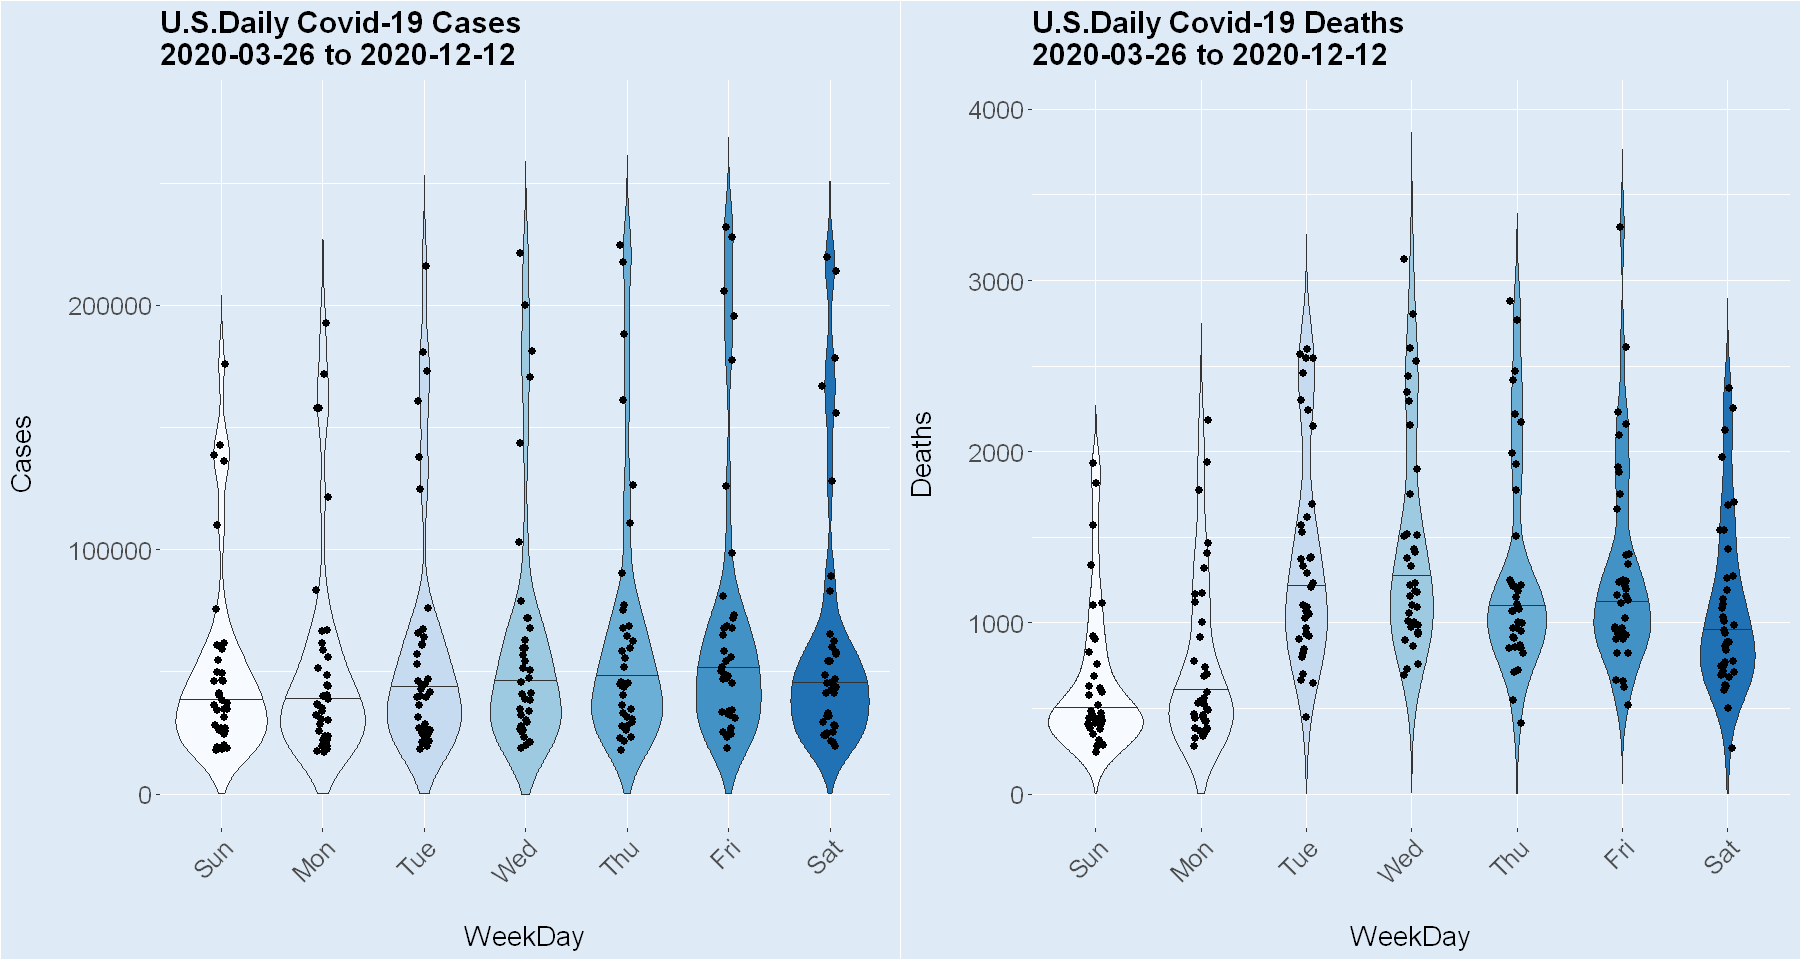

In [79]:
options(repr.plot.width=10, repr.plot.height=10)

pal <- brewer.pal(9,"Blues")

sdate <- ymd("2020-03-26")

work <- casesday()


g1 <- ggplot(work[date>=sdate], aes(x=dayofweek,y=daycases,fill=dayofweek)) +
    geom_violin(trim = FALSE,draw_quantiles = c(0.5)) +
    theme(plot.background = element_rect(fill = pal[2]), 
    panel.background = element_rect(fill = pal[2])) +
    theme(legend.title=element_blank()) +
    theme(legend.position="none") +
    theme(axis.text.x = element_text(size=15, angle = 45, hjust = 1)) +
    theme(axis.text.y = element_text(size=15)) +
    theme(strip.text.x = element_text(size = 5)) +
    theme(text = element_text(size=rel(4))) +
    theme(plot.title = element_text(size=18,face = "bold")) +
    geom_jitter(size=2, position=position_jitter(0.07)) +
    scale_fill_manual(values=pal[1:7]) +
    scale_y_continuous(limits=c(0,1.2*work[,max(daycases)])) +
    labs(title=paste("U.S.Daily Covid-19 Cases\n",work[date>=sdate,min(date)]," to ",work[date>=sdate,max(date)], sep=""), 
         y="Cases\n", x="\nWeekDay")  


g2 <- ggplot(work[date>=sdate], aes(x=dayofweek,y=daydeaths,fill=dayofweek)) +
    geom_violin(trim = FALSE,draw_quantiles = c(0.5)) +
    theme(plot.background = element_rect(fill = pal[2]), 
    panel.background = element_rect(fill = pal[2])) +
    theme(legend.title=element_blank()) +
    theme(legend.position="none") +
    theme(axis.text.x = element_text(size=15, angle = 45, hjust = 1)) +
    theme(axis.text.y = element_text(size=15)) +
    theme(strip.text.x = element_text(size = 5)) +
    theme(text = element_text(size=rel(4))) +
    theme(plot.title = element_text(size=18,face = "bold")) +
    geom_jitter(size=2, position=position_jitter(0.07)) +
    scale_fill_manual(values=pal[1:7]) +
    scale_y_continuous(limits=c(0,1.2*work[,max(daydeaths)])) +
    labs(title=paste("U.S.Daily Covid-19 Deaths\n",work[date>=sdate,min(date)]," to ",work[date>=sdate,max(date)], sep=""), 
         y="Deaths\n", x="\nWeekDay")  


fname <- "violin.jpg"
options(repr.plot.width=15, repr.plot.height=8)

grid.arrange(g1,g2,nrow = 1)#, widths=c(2.5,2.5),clip=TRUE)

ggsave(fname, arrangeGrob(g1,g2,nrow=1),width=15,height=8)



In [80]:
mkgraph <- function(dt,label="U.S.",lags=14)
{

movavg <- function (var, lags) round(frollmean(var,lags))

work <- dt[,.(label=label,cases=sumna(daycases),deaths=sumna(daydeaths)),.(date)][
        ,`:=`(casesma=movavg(cases,lags),deathsma=movavg(deaths,lags))]

caseslag <- tail(work,lags)
casesall <- work[,.(cases=sum(cases),deaths=sum(deaths))]
    
maxcases <- work[casesma==max(casesma,na.rm=TRUE)]
udates <- unique(work$date)
ulen <- length(udates)
qtl <- round(quantile(1:ulen,probs=seq(0,1,1/9)))
grdates <- udates[qtl]

tit <- paste0(lags," Day Moving Average Covid-19 Cases\n",udates[1], " to ",udates[ulen],"\n",label)
foot <- paste0("Last Period: ",caseslag[,first(date)], " to ",caseslag[,last(date)],
               "\nLast Period Cases: ", caseslag[,sum(cases)],
               "\nLast Day Cases: ",caseslag[,last(cases)],
               "\nTotal Cases: ",casesall$cases)

pal <- brewer.pal(9,"Blues")

gp1 <- ggplot(work[!is.na(casesma)],
      aes(x=date,y=casesma)) +
     geom_line(size=1.5,col=pal[9]) +
#     geom_point(size=2,col=pal[9]) +
    geom_vline(aes(xintercept=as.numeric(maxcases$date[1])), na.rm = FALSE, show.legend = NA,col=pal[9],size=.3,linetype=2) +
    scale_y_continuous(limits=c(0,1.2*maxcases$casesma)) +
    scale_x_date(breaks=grdates) +
    theme(plot.background = element_rect(fill = pal[2]), 
    panel.background = element_rect(fill = pal[2])) +
    theme(axis.title=element_text(size=10)) +
    theme(plot.title = element_text (face="bold",size=13)) +
    theme(axis.text = element_text(size=9)) +
    theme(axis.text.x = element_text(angle=45,size=9)) +
    geom_text(data = work[.N], aes(x = date+13,  y = casesma, label = paste0(casesma)),col='black',size=3) +
    labs(title=tit,x="Date\n",y=paste0(lags," Day Moving Average Cases\n"),caption=foot) +
    theme(plot.caption = element_text(hjust = 0,size=11)) 


maxdeaths <- work[deathsma==max(deathsma,na.rm=TRUE)]
udates <- unique(work$date)
ulen <- length(udates)
qtl <- round(quantile(1:ulen,probs=seq(0,1,1/9)))
grdates <- udates[qtl]

tit <- paste0(lags, " Day Moving Average Covid-19 Deaths\n",udates[1], " to ",udates[ulen],"\n",label)
foot <- paste0("Last Period: ",caseslag[,first(date)], " to ",caseslag[,last(date)],
               "\nLast Period Deaths: ", caseslag[,sum(deaths)],
               "\nLast Day Deaths: ", caseslag[,last(deaths)],
               "\nTotal Deaths: ",casesall$deaths)

pal <- brewer.pal(9,"Blues")

gp2 <- ggplot(work,
      aes(x=date,y=deathsma)) +
     geom_line(size=1.5,col=pal[9]) +
#     geom_point(size=2,col=pal[9]) +
    geom_vline(aes(xintercept=as.numeric(maxdeaths$date[1])), na.rm = FALSE, show.legend = NA,col=pal[9],size=.3,linetype=2) +
       scale_y_continuous(limits=c(0,1.2*maxdeaths$deathsma)) +
    scale_x_date(breaks=grdates) +
    theme(plot.background = element_rect(fill = pal[2]), 
    panel.background = element_rect(fill = pal[2])) +
    theme(axis.title=element_text(size=10)) +
    theme(plot.title = element_text (face="bold",size=13)) +
    theme(axis.text = element_text(size=9)) +
    theme(axis.text.x = element_text(angle=45,size=9)) +
    geom_text(data = work[.N], aes(x = date+10,  y = deathsma, label = paste0(deathsma)),col='black',size=3) +
    labs(title=tit,x="Date\n",y=paste0(lags," Day Moving Average Deaths\n"),caption=foot) +
    theme(plot.caption = element_text(hjust = 0,size=11)) 

return(list(gp1,gp2))
    
}

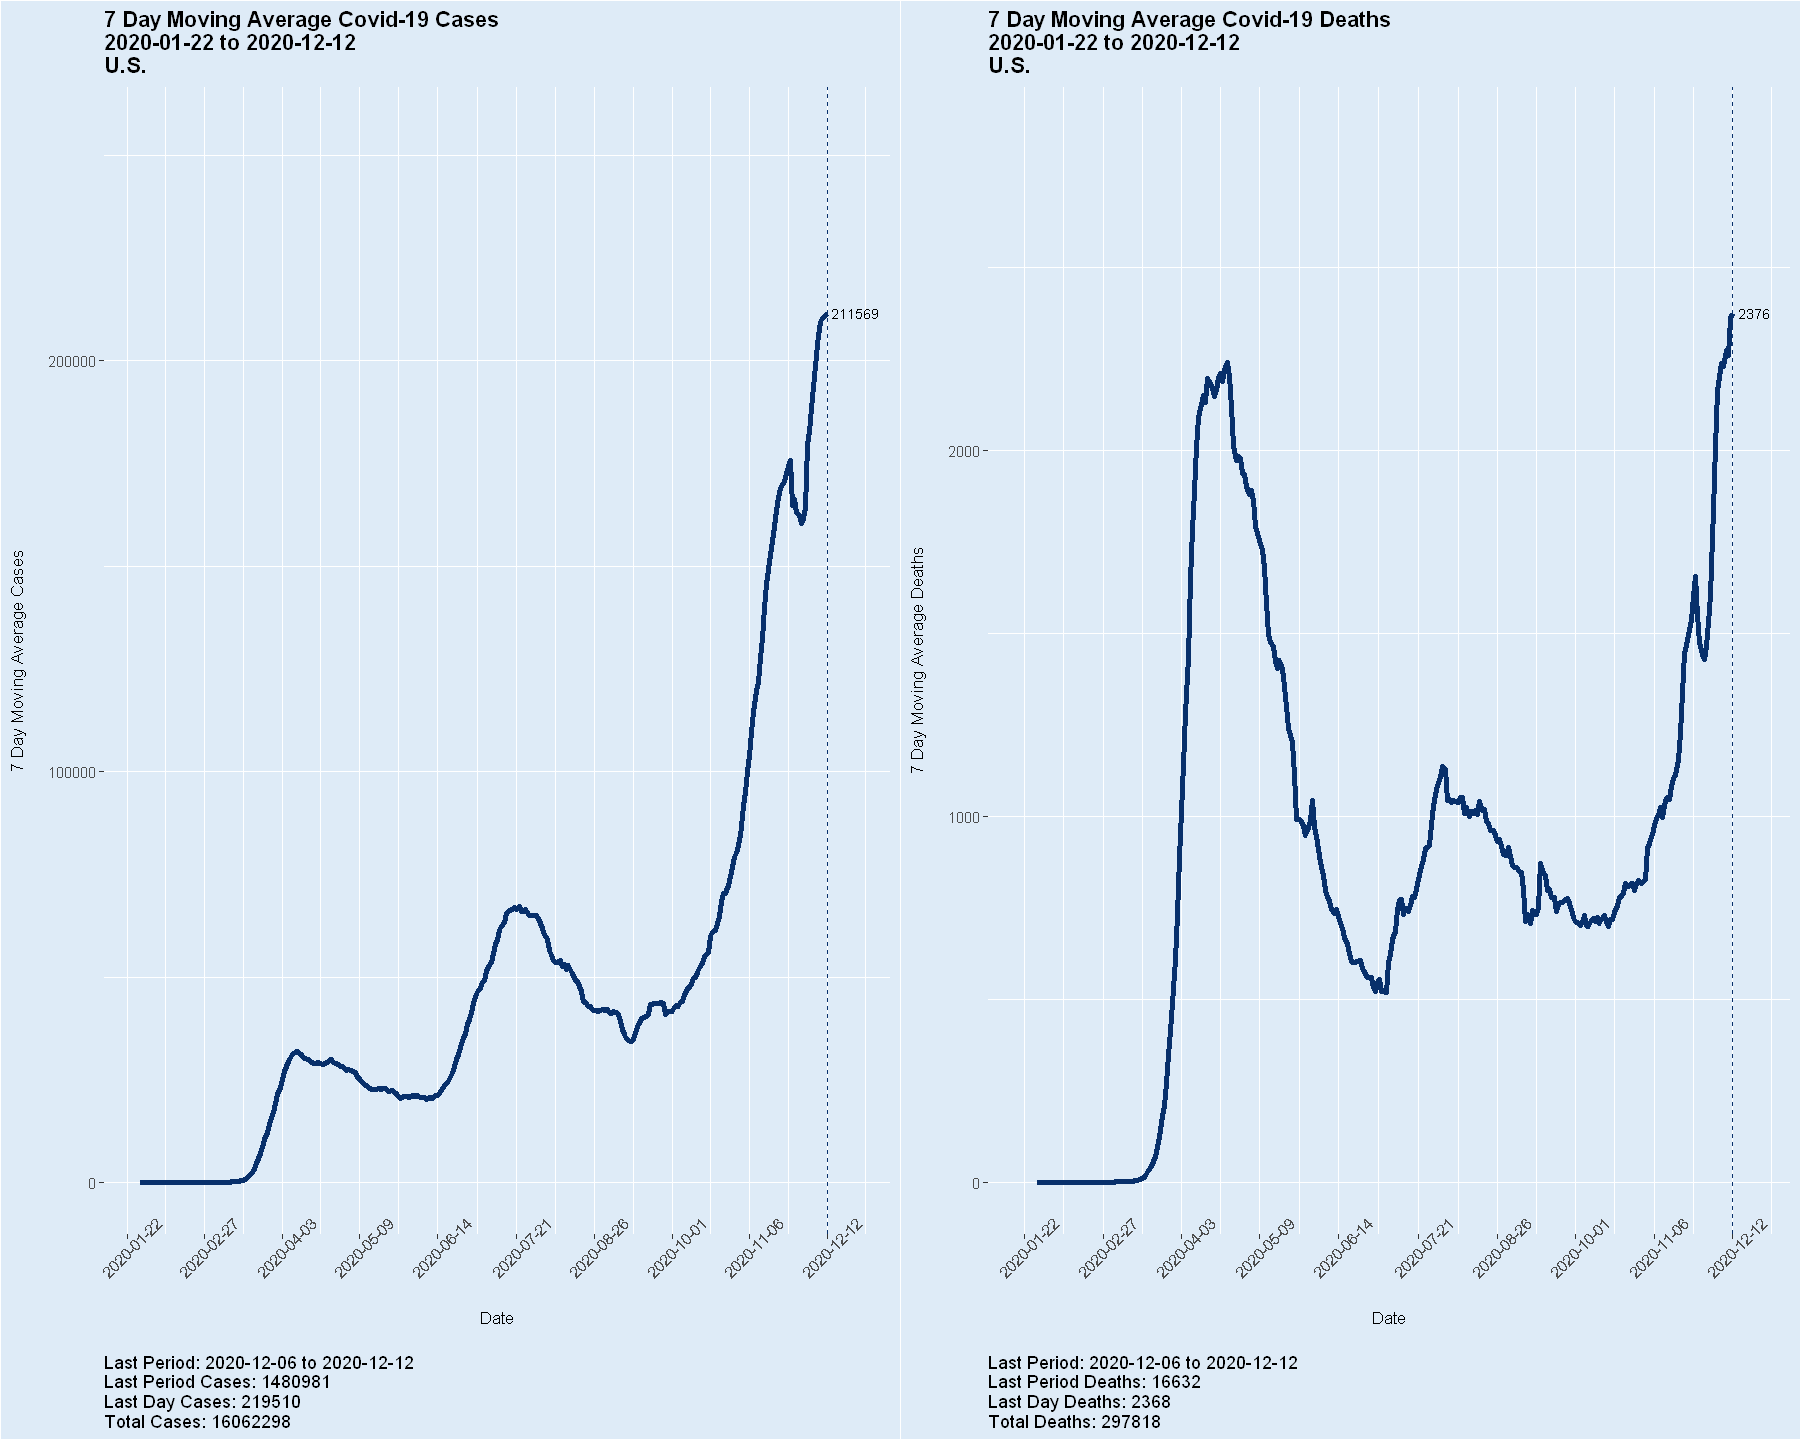

In [81]:

lab <- "U.S." 
lags <- 7

fname = paste0("ma-",lab,"-",lags,".jpg")

grphs <- mkgraph(mfinalus,label=lab,lags=lags)
gp1 <- grphs[[1]]
gp2 <- grphs[[2]]

ggsave(fname, arrangeGrob(gp1,gp2,nrow=1),width=12,height=8)

options(repr.plot.width=15, repr.plot.height=12)

grid.arrange(gp1,gp2,nrow = 1, widths=c(2.5,2.5),clip=FALSE)


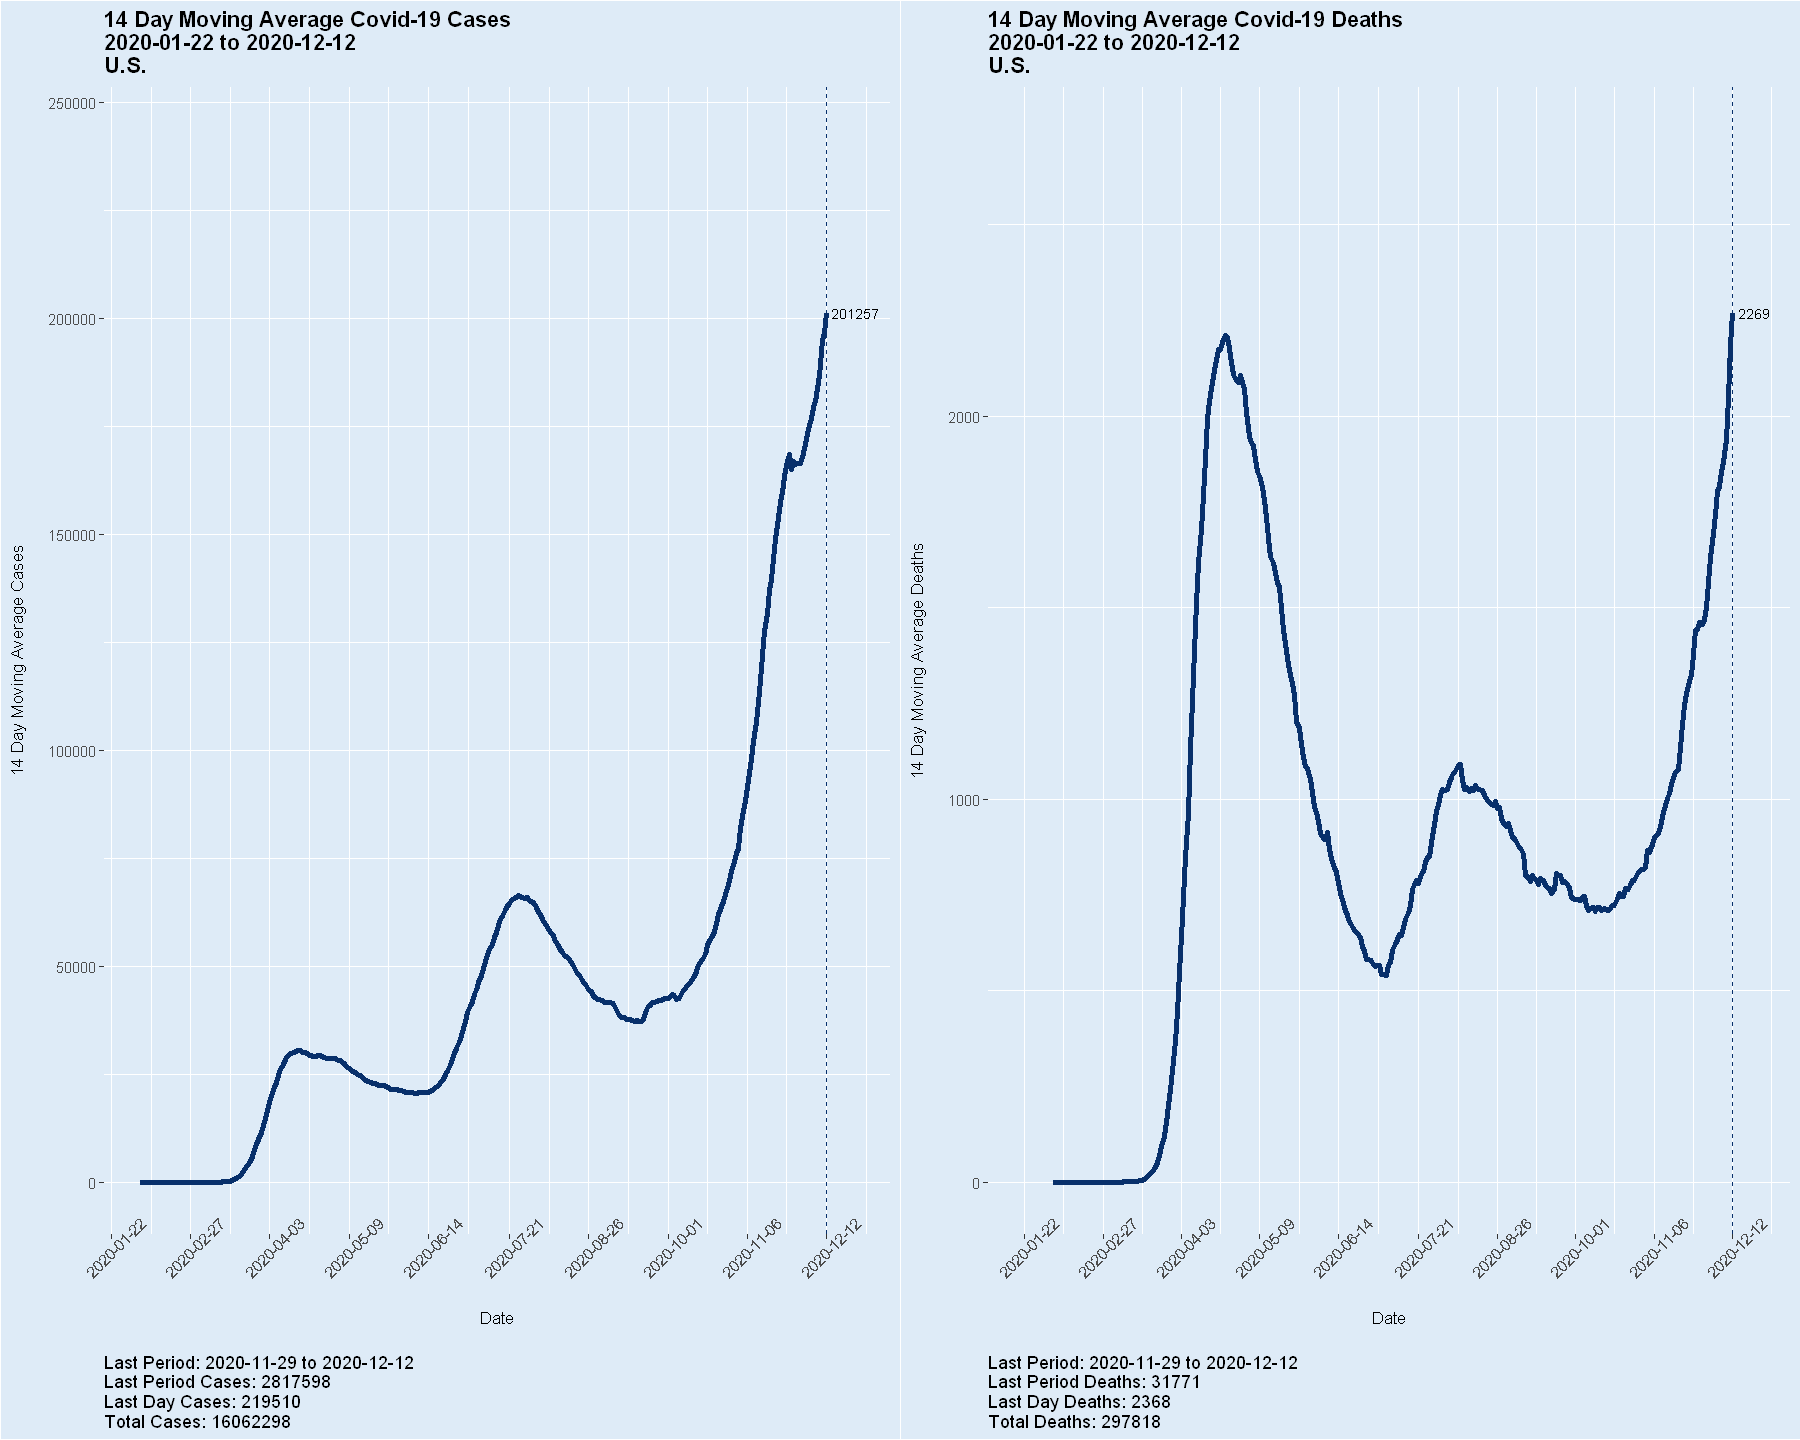

In [82]:

lab <- "U.S." 
lags <- 14

fname = paste0("ma-",lab,"-",lags,".jpg")

grphs <- mkgraph(mfinalus,label=lab,lags=lags)
gp1 <- grphs[[1]]
gp2 <- grphs[[2]]

ggsave(fname, arrangeGrob(gp1,gp2,nrow=1),width=12,height=8)

options(repr.plot.width=15, repr.plot.height=12)

grid.arrange(gp1,gp2,nrow = 1, widths=c(2.5,2.5),clip=FALSE)


In [83]:
tic()

outlist <- c("Guam","Grand Princess","Virgin Islands","Diamond Princess","Northern Mariana Islands","American Samoa","Puerto Rico")
lags <- 7

dowork <- function(lab) 
{

    fname = paste0("ma-",lab,"-",lags,".jpg")
    grphs <- mkgraph(mfinalus[state==lab],label=lab,lags=lags)
    gp1 <- grphs[[1]]
    gp2 <- grphs[[2]]

    ggsave(fname, arrangeGrob(gp1,gp2,nrow=1),width=12,height=8)

}

mfinalus[!is.element(state,outlist),dowork(state),.(state)]

toc()

blanks(2)

state
<fct>


elapsed time is 17.090000 seconds 

 


In [84]:
tic()

outlist <- c("Guam","Grand Princess","Virgin Islands","Diamond Princess","Northern Mariana Islands","American Samoa","Puerto Rico")
lags <- 14

dowork <- function(lab) 
{

    fname = paste0("ma-",lab,"-",lags,".jpg")
    grphs <- mkgraph(mfinalus[state==lab],label=lab,lags=lags)
    gp1 <- grphs[[1]]
    gp2 <- grphs[[2]]

    ggsave(fname, arrangeGrob(gp1,gp2,nrow=1),width=12,height=8)

}

mfinalus[!is.element(state,outlist),dowork(state),.(state)]

toc()

blanks(2)

state
<fct>


elapsed time is 16.840000 seconds 

 


In [85]:
casesday(days=1)
casessum(dt=mfinalus)[.N]

lab,date,dayofweek,daycases,cumcases,daycasesma,daydeaths,cumdeaths,daydeathsma,lag,recnum
<chr>,<date>,<ord>,<int>,<int>,<dbl>,<int>,<int>,<dbl>,<dbl>,<int>
U.S.,2020-12-12,Sat,219510,219510,201257,2368,2368,2269,14,1


lab,days,fdate,tdate,cases,mcases,deaths,mdeaths
<chr>,<int>,<date>,<date>,<int>,<dbl>,<int>,<dbl>
U.S.,326,2020-01-22,2020-12-12,16062298,49271,297818,914


In [86]:
lag <- 14
aggfinalus <- mfinalus[,.(cases=sumna(daycases),deaths=sumna(daydeaths)),.(date)][,`:=`(cumcases=cumsum(cases),cumdeaths=cumsum(deaths))]

setcolorder(aggfinalus[,`:=`(casesms=frollsum(cases,lag,align="right"),deathsms=frollsum(deaths,lag,align="right"))][
    ,`:=`(cf=round(100*(deaths/cases),3),cfcum=round(100*(cumdeaths/cumcases),3),cfms=round(100*(deathsms/casesms),3),lag=lag,recnum=.I)],   
         c("recnum","lag","date","cases","cumcases","casesms","deaths","cumdeaths","deathsms","cf","cfcum","cfms"))
aggfinalus[,`:=`('up?'=ifelse(diffna(cfms)>0,'+','-'))]

meta(aggfinalus)

mykab(aggfinalus[date>="2020-03-01"])



|name      |class                 |rows|columns|size    |
|:---------|:---------------------|:---|:------|:-------|
|aggfinalus|data.table, data.frame|326 |13     |29.56 KB|

Classes 'data.table' and 'data.frame':	326 obs. of  13 variables:
 $ recnum   : int  1 2 3 4 5 6 7 8 9 10 ...
 $ lag      : num  14 14 14 14 14 14 14 14 14 14 ...
 $ date     : Date, format: "2020-01-22" "2020-01-23" ...
 $ cases    : int  0 0 1 0 3 0 0 1 0 2 ...
 $ cumcases : int  0 0 1 1 4 4 4 5 5 7 ...
 $ casesms  : num  NA NA NA NA NA NA NA NA NA NA ...
 $ deaths   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ cumdeaths: int  0 0 0 0 0 0 0 0 0 0 ...
 $ deathsms : num  NA NA NA NA NA NA NA NA NA NA ...
 $ cf       : num  NaN NaN 0 NaN 0 NaN NaN 0 NaN 0 ...
 $ cfcum    : num  NaN NaN 0 0 0 0 0 0 0 0 ...
 $ cfms     : num  NA NA NA NA NA NA NA NA NA NA ...
 $ up?      : chr  NA NA NA NA ...
 - attr(*, ".internal.selfref")=<externalptr> 
NULL




|recnum|lag|date      |cases |cumcases|casesms|deaths|cumdeaths|deathsms|cf    |cfcum |cfms  |up?|
|:-----|:--|:---------|:-----|:-------|:------|:-----|:--------|:-------|:-----|:-----|:-----|:--|
|40    |14 |2020-03-01|7     |31      |18     |0     |1        |1       |0.000 |3.226 |5.556 |-  |
|41    |14 |2020-03-02|23    |54      |41     |5     |6        |6       |21.739|11.111|14.634|+  |
|42    |14 |2020-03-03|19    |73      |60     |1     |7        |7       |5.263 |9.589 |11.667|-  |
|43    |14 |2020-03-04|33    |106     |93     |4     |11       |11      |12.121|10.377|11.828|+  |
|44    |14 |2020-03-05|77    |183     |170    |1     |12       |12      |1.299 |6.557 |7.059 |-  |
|45    |14 |2020-03-06|53    |236     |221    |2     |14       |14      |3.774 |5.932 |6.335 |-  |
|46    |14 |2020-03-07|166   |402     |387    |3     |17       |17      |1.807 |4.229 |4.393 |-  |
|47    |14 |2020-03-08|116   |518     |503    |4     |21       |21      |3.448 |4.054 |4.175 |-  |
|48    |

In [87]:
mkcfdata <- function(dt=aggfinalus)
{

        slug <- melt(dt, id.vars=c(2,3),measure.vars=c(10:12),variable.name="type",value.name="casefatality")
        slug[,`:=`(type=factor(type, levels=c("cf","cfms","cfcum"), labels=c("Daily CF",paste0(last(lag)," Day Rolling Sum CF"),"Cumulative CF")))]
}

work <- mkcfdata(aggfinalus)


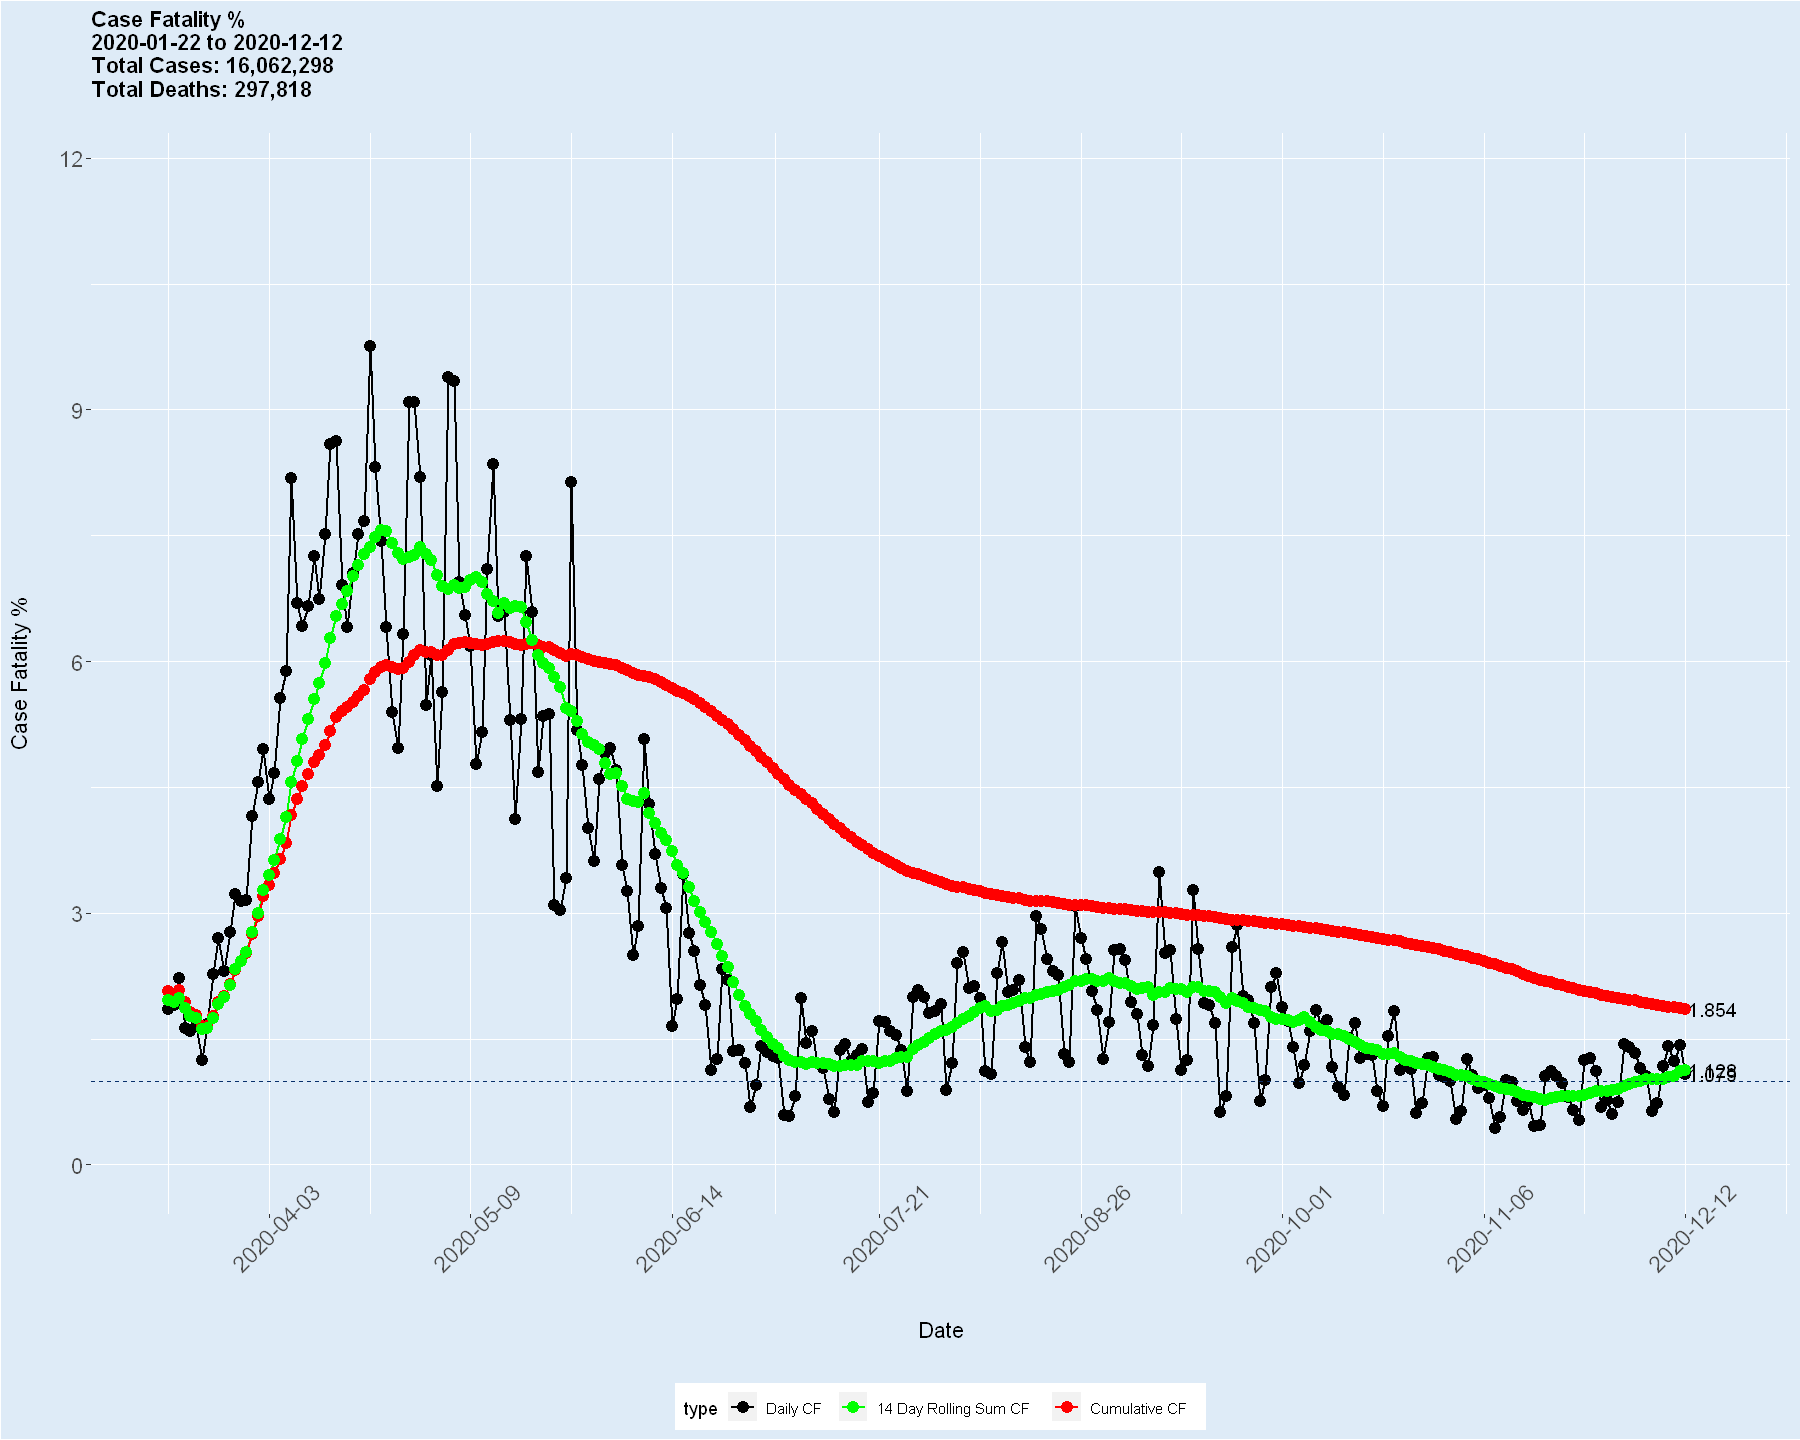

In [88]:
mx <- work[date>="2020-03-16",max(casefatality)]

udates <- unique(work$date)
ulen <- length(udates)
qtl <- round(quantile(1:ulen,probs=seq(0,1,1/9)))
grdates <- udates[qtl]

tit <- paste0("Case Fatality %\n",aggfinalus[,first(date)]," to ",aggfinalus[,last(date)],
             "\nTotal Cases: ",format(aggfinalus[.N]$cumcases,big.mark=","),
             "\nTotal Deaths: ",format(aggfinalus[.N]$cumdeaths,big.mark=","),"\n")

foot <- paste0("Period: ",work[,first(date)], " to ",work[,last(date)],
              "\nTotal Deaths: ",work[,last(casefatality)])
anno0 <- work[type=="Daily CF"][.N]
anno1 <- work[type=="14 Day Rolling Sum CF"][.N]
anno2 <- work[type=="Cumulative CF"][.N]

pal <- brewer.pal(9,"Blues")

gp <- ggplot(work[date>="2020-03-16"],
      aes(x=date,y=casefatality,color=type)) +
     geom_line(size=.8) +
     geom_point(size=3) +
    geom_hline(aes(yintercept=1), na.rm = FALSE, show.legend = NA,col=pal[9],size=.3,linetype=2) +
    theme(plot.background = element_rect(fill = pal[2]), 
    panel.background = element_rect(fill = pal[2])) +
    theme(axis.title=element_text(size=13)) +
    theme(plot.title = element_text (face="bold",size=13)) +
    theme(axis.text = element_text(size=13)) +
    theme(axis.text.x = element_text(angle=45)) +

    scale_color_manual(breaks = c(levels(work$type)[1],
                                  levels(work$type)[2],
                                  levels(work$type)[3]),
                       values=c("black", "green", "red")) +

    scale_y_continuous(limits=c(0,1.2*mx)) +
    scale_x_date(breaks=grdates) +
    labs(title=tit,x="Date\n",y="Case Fatality %\n") + #,caption=foot) +
    theme(plot.caption = element_text(hjust = 0,size=10)) +
    theme(legend.position="bottom") +
    geom_text(data = anno0, aes(x = date+5,  y = casefatality, label = casefatality),col='black',size=4) +
    geom_text(data = anno1, aes(x = date+5,  y = casefatality, label = casefatality),col='black',size=4) +
    geom_text(data = anno2, aes(x = date+5,  y = casefatality, label = casefatality),col='black',size=4) 

print(gp)


In [89]:
wdir <- "/steve/covid/magrsave"
setwd(wdir)


fname <- "casefatality.jpg"

jpeg(file=fname,width = 864, height = 720)
#jpeg(file=fname)
gp
dev.off()


png 
  2

In [90]:
periodsperyear <- 364/work[.N]$lag


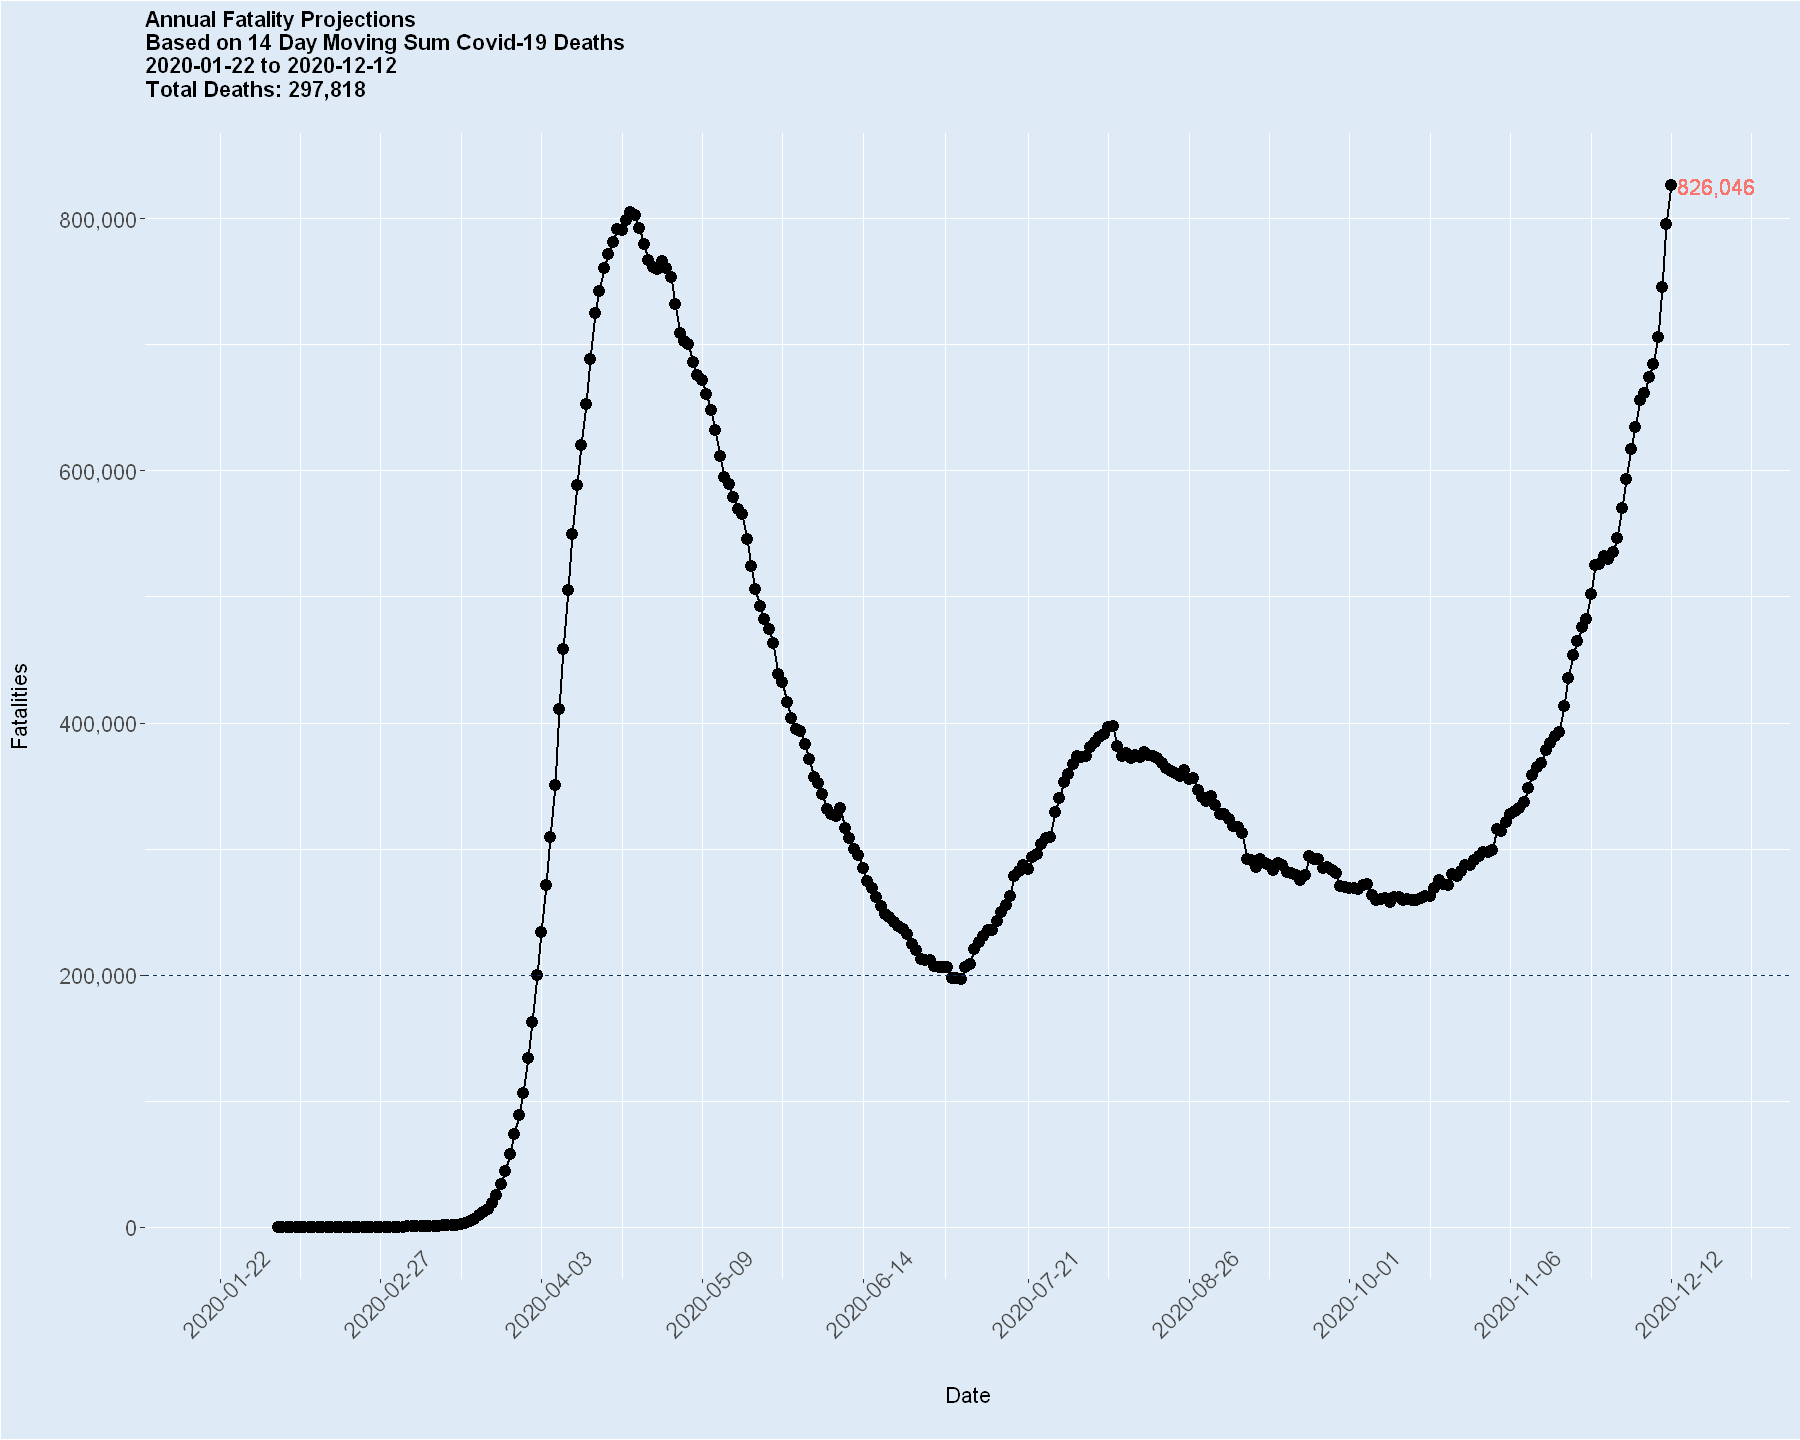

In [91]:
work <- aggfinalus

periodsperyear <- 364/work[.N]$lag

mx <- work[,max(deathsms)]*periodsperyear
last <- work[,last(deathsms)]*periodsperyear


udates <- unique(work$date)
ulen <- length(udates)
qtl <- round(quantile(1:ulen,probs=seq(0,1,1/9)))
grdates <- udates[qtl]

tit <- paste0("Annual Fatality Projections\nBased on ",work[,last(lag)]," Day Moving Sum Covid-19 Deaths\n",udates[1], " to ",udates[ulen],
             "\nTotal Deaths: ",format(work[,last(cumdeaths)],big.mark=","),"\n")

foot <- paste0("Period: ",work[,first(date)], " to ",work[,last(date)],
              "\nTotal Deaths: ",format(work[,last(cumdeaths)],big.mark=","))


gp <- ggplot(aggfinalus,
      aes(x=date,y=deathsms*periodsperyear)) +
     geom_line(size=.8) +
     geom_point(size=3) +
    geom_hline(aes(yintercept=200000),col=pal[9],size=.3,linetype=2) +
    theme(plot.background = element_rect(fill = pal[2]), 
    panel.background = element_rect(fill = pal[2])) +
    theme(axis.title=element_text(size=13)) +
    theme(plot.title = element_text (face="bold",size=13)) +
    theme(axis.text = element_text(size=13)) +
    theme(axis.text.x = element_text(angle=45)) +
    scale_y_continuous(limits=c(0,1.5*mx),labels = scales::comma) +
    scale_x_date(breaks=grdates) +
    labs(title=tit,x="Date\n",y="Fatalities\n") + #, caption=foot) +
    theme(plot.caption = element_text(hjust = 0,size=12)) +
    theme(legend.position = "none") +
    geom_text(data = work, aes(x = last(date)+10,  y = work[,last(deathsms)]*periodsperyear, label = format(work[,last(deathsms)]*periodsperyear,big.mark=","),col='black',size=4))
print(gp)
#format(12345.678,big.mark=",",scientific=FALSE)

In [92]:
wdir <- "/steve/covid/magrsave"
setwd(wdir)


fname <- "fatalityprojections.jpg"

jpeg(file=fname,width = 864, height = 720)
#jpeg(file=fname)
gp
dev.off()


png 
  2

In [93]:
forcovid <- function(dt=aggfinalus,tdate="2020-12-31")
{
    last = dt[.N]
    fdays <- as.integer((ymd(tdate)+1) - (last$date+1))
    
    deathsnow <- last$cumdeaths
    deathsinterval <- round(last$deathsms/last$lag)*fdays
   
    forecast <- data.table(fdate=last$date+1,tdate=tdate,fdays=fdays,deathsnow=deathsnow,deathsinterval=deathsinterval,deathsforecast=deathsnow+deathsinterval)
    return(forecast)
}

In [94]:
#mykab(forcovid(tdate="2020-09-07"))
#mykab(forcovid(tdate="2020-11-03"))
mykab(forcovid(tdate="2020-11-30"))
mykab(forcovid(tdate="2021-01-20"))
mykab(forcovid())




|fdate     |tdate     |fdays|deathsnow|deathsinterval|deathsforecast|
|:---------|:---------|:----|:--------|:-------------|:-------------|
|2020-12-13|2020-11-30|-12  |297818   |-27228        |270590        |



|fdate     |tdate     |fdays|deathsnow|deathsinterval|deathsforecast|
|:---------|:---------|:----|:--------|:-------------|:-------------|
|2020-12-13|2021-01-20|39   |297818   |88491         |386309        |



|fdate     |tdate     |fdays|deathsnow|deathsinterval|deathsforecast|
|:---------|:---------|:----|:--------|:-------------|:-------------|
|2020-12-13|2020-12-31|19   |297818   |43111         |340929        |

In [95]:
options(warn=-1) 
options(scipen = 20)
options(datatable.print.topn=100)
options(datatable.showProgress=FALSE)

usualsuspects <- c(
    'tidyverse', 'data.table', 'pryr', 'plyr','readxl', 'bit', 'grid', 'gridExtra',     
    'rvest', 'magrittr','lubridate','rlist', 'tictoc', 'skimr','pracma','TTR',
    'fst','feather','rio', 'Rcpp',
    'knitr', 'kableExtra',  
    'ggplot2','RColorBrewer',
    'incidence','outbreaks','EpiEstim','forecast'
) 

suppressMessages(invisible(lapply(usualsuspects, library, character.only = TRUE)))

funcsdir <- "/steve/r/functions"
funcsfile <- "rfunctions.r"

setwd(funcsdir)
source(funcsfile)

cppdir <- "c:/steve/c++/rstudio"
setwd(cppdir)

cppfile <- "cppfuncs.cpp"
sourceCpp(cppfile)

blanks(1)
lsf.str()

wdir <- "/steve/covid/magrsave"
setwd(wdir)

blanks(2)

allfreqs : function (dtn, catlim = 100)  
blanks : function (howmany)  
casefatality : function (dt = mfinalus, lab = "U.S.", mdate = "2020-05-26")  
casesday : function (dt = mfinalus, days = 1000, lag = 14, lab = "U.S.")  
casessum : function (dt = mfinalus, fdate = NULL, tdate = NULL, days = NULL, lab = "U.S.")  
ccollapse : function (x)  
ccrollsum : function (x, window = 7L)  
cdiff : function (x)  
clonedf : function (df)  
colsize : function (dt)  
copydf : function (df)  
cpctch : function (x)  
crev : function (x)  
crollsum : function (x, window = 7L, wtype = "right")  
crollsumo : function (x, window = 7L)  
cseq : function (m, n)  
csum : function (x)  
ctable : function (x)  
ctail : function (x)  
cumsum_sug : function (x)  
cumsum1 : function (x)  
cumsum2 : function (x)  
cumsumcpp : function (x)  
diffna : function (var)  
do_stuff : function (df)  
doubler : function (x)  
dowork : function (lab)  
dtmeta : function (df)  
forcovid : function (dt = aggfinalus, tdate =

Define several convenience functions that do nothing more than save typing.

In [96]:
diffna <- function (var) c(NA,diff(var))
sumna <- function (var) sum(var,na.rm=TRUE)
meanna <- function (var) round(mean(var,na.rm=TRUE))
freadfac <- function (var) fread(var,stringsAsFactors=TRUE)
fstrddt <- function(var) read_fst(var,as.data.table=TRUE)
movavg <- function (var, lags) round(frollmean(var,lags))
meancov <- function(var) round(mean(var))
wkday <- function(dt) lubridate::wday(dt,label=TRUE)

blanks(2)

In [97]:
burl = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series"

fname <- "time_series_covid19_confirmed_global.csv"

covidcasesworld <-  freadfac(file.path(burl, fname)) 

meta(covidcasesworld)

blanks(2)



|name           |class                 |rows|columns|size     |
|:--------------|:---------------------|:---|:------|:--------|
|covidcasesworld|data.table, data.frame|271 |330    |411.91 KB|

Classes 'data.table' and 'data.frame':	271 obs. of  330 variables:
 $ Province/State: Factor w/ 84 levels "","Alberta","Anguilla",..: 1 1 1 1 1 1 1 1 6 50 ...
 $ Country/Region: Factor w/ 191 levels "Afghanistan",..: 1 2 3 4 5 6 7 8 9 9 ...
 $ Lat           : num  33.9 41.2 28 42.5 -11.2 ...
 $ Long          : num  67.71 20.17 1.66 1.52 17.87 ...
 $ 1/22/20       : int  0 0 0 0 0 0 0 0 0 0 ...
 $ 1/23/20       : int  0 0 0 0 0 0 0 0 0 0 ...
 $ 1/24/20       : int  0 0 0 0 0 0 0 0 0 0 ...
 $ 1/25/20       : int  0 0 0 0 0 0 0 0 0 0 ...
 $ 1/26/20       : int  0 0 0 0 0 0 0 0 0 3 ...
 $ 1/27/20       : int  0 0 0 0 0 0 0 0 0 4 ...
 $ 1/28/20       : int  0 0 0 0 0 0 0 0 0 4 ...
 $ 1/29/20       : int  0 0 0 0 0 0 0 0 0 4 ...
 $ 1/30/20       : int  0 0 0 0 0 0 0 0 0 4 ...
 $ 1/31/20       : int  

In [98]:
tail(names(covidcasesworld))

[1] "12/7/20"  "12/8/20"  "12/9/20"  "12/10/20" "12/11/20" "12/12/20"

In [99]:
nc <- ncol(covidcasesworld)
startdt <- 5

varnums <- startdt:nc

mcovidcasesworld <- melt(covidcasesworld,measure.vars=varnums,variable.name="date",value.name="cumcases")[
    ,date:=mdy(date)]

names(mcovidcasesworld) <- gsub("/","",tolower(names(mcovidcasesworld)))
mcovidcasesworld <- mcovidcasesworld[order(countryregion,provincestate,date)][,c(2,1,3:6)][,`:=`(daycases=diffna(cumcases)),.(countryregion,provincestate)] 
setkey(mcovidcasesworld,countryregion,provincestate,date)

meta(mcovidcasesworld)



|name            |class                 |rows |columns|size   |
|:---------------|:---------------------|:----|:------|:------|
|mcovidcasesworld|data.table, data.frame|88346|7      |3.39 MB|

Classes 'data.table' and 'data.frame':	88346 obs. of  7 variables:
 $ countryregion: Factor w/ 191 levels "Afghanistan",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ provincestate: Factor w/ 84 levels "","Alberta","Anguilla",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ lat          : num  33.9 33.9 33.9 33.9 33.9 ...
 $ long         : num  67.7 67.7 67.7 67.7 67.7 ...
 $ date         : Date, format: "2020-01-22" "2020-01-23" ...
 $ cumcases     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ daycases     : int  NA 0 0 0 0 0 0 0 0 0 ...
 - attr(*, ".internal.selfref")=<externalptr> 
 - attr(*, "sorted")= chr [1:3] "countryregion" "provincestate" "date"
NULL


In [100]:
burl = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series"

fname <- "time_series_covid19_deaths_global.csv"

coviddeathsworld <-  freadfac(file.path(burl, fname)) 

meta(coviddeathsworld)

blanks(2)



|name            |class                 |rows|columns|size     |
|:---------------|:---------------------|:---|:------|:--------|
|coviddeathsworld|data.table, data.frame|271 |330    |411.91 KB|

Classes 'data.table' and 'data.frame':	271 obs. of  330 variables:
 $ Province/State: Factor w/ 84 levels "","Alberta","Anguilla",..: 1 1 1 1 1 1 1 1 6 50 ...
 $ Country/Region: Factor w/ 191 levels "Afghanistan",..: 1 2 3 4 5 6 7 8 9 9 ...
 $ Lat           : num  33.9 41.2 28 42.5 -11.2 ...
 $ Long          : num  67.71 20.17 1.66 1.52 17.87 ...
 $ 1/22/20       : int  0 0 0 0 0 0 0 0 0 0 ...
 $ 1/23/20       : int  0 0 0 0 0 0 0 0 0 0 ...
 $ 1/24/20       : int  0 0 0 0 0 0 0 0 0 0 ...
 $ 1/25/20       : int  0 0 0 0 0 0 0 0 0 0 ...
 $ 1/26/20       : int  0 0 0 0 0 0 0 0 0 0 ...
 $ 1/27/20       : int  0 0 0 0 0 0 0 0 0 0 ...
 $ 1/28/20       : int  0 0 0 0 0 0 0 0 0 0 ...
 $ 1/29/20       : int  0 0 0 0 0 0 0 0 0 0 ...
 $ 1/30/20       : int  0 0 0 0 0 0 0 0 0 0 ...
 $ 1/31/20       : in

In [101]:
nc <- ncol(coviddeathsworld)
startdt <- 5

varnums <- startdt:nc

mcoviddeathsworld <- melt(coviddeathsworld,measure.vars=varnums,variable.name="date",value.name="cumdeaths")[
    ,date:=mdy(date)]

names(mcoviddeathsworld) <- gsub("/","",tolower(names(mcoviddeathsworld)))
mcoviddeathsworld <- mcoviddeathsworld[order(countryregion,provincestate,date)][,c(2,1,3:6)][,`:=`(daydeaths=diffna(cumdeaths)),.(countryregion,provincestate)] 
setkey(mcoviddeathsworld,countryregion,provincestate,date)

meta(mcoviddeathsworld)



|name             |class                 |rows |columns|size   |
|:----------------|:---------------------|:----|:------|:------|
|mcoviddeathsworld|data.table, data.frame|88346|7      |3.39 MB|

Classes 'data.table' and 'data.frame':	88346 obs. of  7 variables:
 $ countryregion: Factor w/ 191 levels "Afghanistan",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ provincestate: Factor w/ 84 levels "","Alberta","Anguilla",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ lat          : num  33.9 33.9 33.9 33.9 33.9 ...
 $ long         : num  67.7 67.7 67.7 67.7 67.7 ...
 $ date         : Date, format: "2020-01-22" "2020-01-23" ...
 $ cumdeaths    : int  0 0 0 0 0 0 0 0 0 0 ...
 $ daydeaths    : int  NA 0 0 0 0 0 0 0 0 0 ...
 - attr(*, ".internal.selfref")=<externalptr> 
 - attr(*, "sorted")= chr [1:3] "countryregion" "provincestate" "date"
NULL


In [102]:
mfinalworld <- mcovidcasesworld[mcoviddeathsworld][,-c(8:9)] #%>% setnames("province_state", "state")
meta(mfinalworld)




|name       |class                 |rows |columns|size   |
|:----------|:---------------------|:----|:------|:------|
|mfinalworld|data.table, data.frame|88346|9      |4.07 MB|

Classes 'data.table' and 'data.frame':	88346 obs. of  9 variables:
 $ countryregion: Factor w/ 191 levels "Afghanistan",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ provincestate: Factor w/ 84 levels "","Alberta","Anguilla",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ lat          : num  33.9 33.9 33.9 33.9 33.9 ...
 $ long         : num  67.7 67.7 67.7 67.7 67.7 ...
 $ date         : Date, format: "2020-01-22" "2020-01-23" ...
 $ cumcases     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ daycases     : int  NA 0 0 0 0 0 0 0 0 0 ...
 $ cumdeaths    : int  0 0 0 0 0 0 0 0 0 0 ...
 $ daydeaths    : int  NA 0 0 0 0 0 0 0 0 0 ...
 - attr(*, "sorted")= chr [1:3] "countryregion" "provincestate" "date"
 - attr(*, ".internal.selfref")=<externalptr> 
NULL


In [103]:
wdir <- "c:/steve/covid/world"
setwd(wdir)

fname <- paste0("mfinalworld-",mfinalworld[,max(date)],".fst")
write_fst(mfinalworld,fname)

fname <- paste0("mfinalworld-",mfinalworld[,max(date)],".feather")
export(mfinalworld,fname)

setkey(mfinalworld,countryregion,provincestate,date)

meta(mfinalworld)

blanks(2)



|name       |class                 |rows |columns|size   |
|:----------|:---------------------|:----|:------|:------|
|mfinalworld|data.table, data.frame|88346|9      |4.07 MB|

Classes 'data.table' and 'data.frame':	88346 obs. of  9 variables:
 $ countryregion: Factor w/ 191 levels "Afghanistan",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ provincestate: Factor w/ 84 levels "","Alberta","Anguilla",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ lat          : num  33.9 33.9 33.9 33.9 33.9 ...
 $ long         : num  67.7 67.7 67.7 67.7 67.7 ...
 $ date         : Date, format: "2020-01-22" "2020-01-23" ...
 $ cumcases     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ daycases     : int  NA 0 0 0 0 0 0 0 0 0 ...
 $ cumdeaths    : int  0 0 0 0 0 0 0 0 0 0 ...
 $ daydeaths    : int  NA 0 0 0 0 0 0 0 0 0 ...
 - attr(*, "sorted")= chr [1:3] "countryregion" "provincestate" "date"
 - attr(*, ".internal.selfref")=<externalptr> 
NULL

 


In [104]:
mykab(tail(mfinalworld,20))



|countryregion|provincestate|lat      |long    |date      |cumcases|daycases|cumdeaths|daydeaths|
|:------------|:------------|:--------|:-------|:---------|:-------|:-------|:--------|:--------|
|Zimbabwe     |             |-19.01544|29.15486|2020-11-23|9308    |88      |273      |5        |
|Zimbabwe     |             |-19.01544|29.15486|2020-11-24|9398    |90      |274      |1        |
|Zimbabwe     |             |-19.01544|29.15486|2020-11-25|9508    |110     |274      |0        |
|Zimbabwe     |             |-19.01544|29.15486|2020-11-26|9623    |115     |274      |0        |
|Zimbabwe     |             |-19.01544|29.15486|2020-11-27|9714    |91      |275      |1        |
|Zimbabwe     |             |-19.01544|29.15486|2020-11-28|9822    |108     |275      |0        |
|Zimbabwe     |             |-19.01544|29.15486|2020-11-29|9822    |0       |275      |0        |
|Zimbabwe     |             |-19.01544|29.15486|2020-11-30|9950    |128     |276      |1        |
|Zimbabwe     |   

In [105]:
mykab(mfinalworld[,.(cases=sumna(daycases),deaths=sumna(daydeaths))])



|cases   |deaths |
|:-------|:------|
|71704330|1605000|

In [106]:
meta(mfinalworld)



|name       |class                 |rows |columns|size   |
|:----------|:---------------------|:----|:------|:------|
|mfinalworld|data.table, data.frame|88346|9      |4.07 MB|

Classes 'data.table' and 'data.frame':	88346 obs. of  9 variables:
 $ countryregion: Factor w/ 191 levels "Afghanistan",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ provincestate: Factor w/ 84 levels "","Alberta","Anguilla",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ lat          : num  33.9 33.9 33.9 33.9 33.9 ...
 $ long         : num  67.7 67.7 67.7 67.7 67.7 ...
 $ date         : Date, format: "2020-01-22" "2020-01-23" ...
 $ cumcases     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ daycases     : int  NA 0 0 0 0 0 0 0 0 0 ...
 $ cumdeaths    : int  0 0 0 0 0 0 0 0 0 0 ...
 $ daydeaths    : int  NA 0 0 0 0 0 0 0 0 0 ...
 - attr(*, "sorted")= chr [1:3] "countryregion" "provincestate" "date"
 - attr(*, ".internal.selfref")=<externalptr> 
NULL


In [107]:
setkey(mfinalworld,countryregion,provincestate,date)

mfinalworld["Taiwan*",countryregion:="Taiwan"]

In [108]:
mykab(mfinalworld[,.(cases=sumna(daycases),deaths=sumna(daydeaths)),.(countryregion)][order(-cases)])



|countryregion                   |cases   |deaths|
|:-------------------------------|:-------|:-----|
|US                              |16062298|297818|
|India                           |9857029 |143019|
|Brazil                          |6880127 |181123|
|Russia                          |2602048 |45923 |
|France                          |2405255 |57671 |
|United Kingdom                  |1835949 |64123 |
|Italy                           |1825775 |64036 |
|Turkey                          |1809809 |16199 |
|Spain                           |1730575 |47624 |
|Argentina                       |1494602 |40668 |
|Colombia                        |1417072 |38866 |
|Germany                         |1336101 |21900 |
|Mexico                          |1241436 |113704|
|Poland                          |1126700 |22676 |
|Iran                            |1100818 |51949 |
|Peru                            |980943  |36544 |
|Ukraine                         |908839  |15528 |
|South Africa                

In [109]:
mkgraph <- function(dt,label="World",lags=14)
{

movavg <- function (var, lags) round(frollmean(var,lags))

work <- dt[,.(label=label,cases=sumna(daycases),deaths=sumna(daydeaths)),.(date)][
        ,`:=`(casesma=movavg(cases,lags),deathsma=movavg(deaths,lags))]

caseslag <- tail(work,lags)
casesall <- work[,.(cases=sum(cases),deaths=sum(deaths))]
    
maxcases <- work[casesma==max(casesma,na.rm=TRUE)]
udates <- unique(work$date)
ulen <- length(udates)
qtl <- round(quantile(1:ulen,probs=seq(0,1,1/9)))
grdates <- udates[qtl]

tit <- paste0(lags," Day Moving Average Covid-19 Cases\n",udates[1], " to ",udates[ulen],"\n",label)
foot <- paste0("Last Period: ",caseslag[,first(date)], " to ",caseslag[,last(date)],
               "\nLast Period Cases: ", format(caseslag[,sum(cases)],big.mark=","),
               "\nLast Day Cases: ",format(caseslag[,last(cases)],big.mark=","),
               "\nTotal Cases: ",format(casesall$cases,big.mark=","))

pal <- brewer.pal(9,"Blues")

gp1 <- ggplot(work[!is.na(casesma)],
      aes(x=date,y=casesma)) +
     geom_line(size=1,col=pal[9]) +
     geom_point(size=2,col=pal[9]) +
    geom_vline(aes(xintercept=as.numeric(maxcases$date[1])), na.rm = FALSE, show.legend = NA,col=pal[9],size=.3,linetype=2) +
    scale_y_continuous(limits=c(0,1.2*maxcases$casesma)) +
    scale_x_date(breaks=grdates) +
    theme(plot.background = element_rect(fill = pal[2]), 
    panel.background = element_rect(fill = pal[2])) +
    theme(axis.title=element_text(size=10)) +
    theme(plot.title = element_text (face="bold",size=13)) +
    theme(axis.text = element_text(size=9)) +
    theme(axis.text.x = element_text(angle=45,size=9)) +
    geom_text(data = work[.N], aes(x = date+15,  y = casesma, label = format(casesma,big.mark=",")),col='black',size=3) +
    labs(title=tit,x="Date\n",y=paste0(lags," Day Moving Average Cases\n"),caption=foot) +
    theme(plot.caption = element_text(hjust = 0,size=11)) 


maxdeaths <- work[deathsma==max(deathsma,na.rm=TRUE)]
udates <- unique(work$date)
ulen <- length(udates)
qtl <- round(quantile(1:ulen,probs=seq(0,1,1/9)))
grdates <- udates[qtl]

tit <- paste0(lags, " Day Moving Average Covid-19 Deaths\n",udates[1], " to ",format(udates[ulen],big.mark=","),"\n",label)
foot <- paste0("Last Period: ",caseslag[,first(date)], " to ",caseslag[,last(date)],
               "\nLast Period Deaths: ", format(caseslag[,sum(deaths)],big.mark=","),
               "\nLast Day Deaths: ", format(caseslag[,last(deaths)],big.mark=","),
               "\nTotal Deaths: ",format(casesall$deaths,big.mark=","))

pal <- brewer.pal(9,"Blues")

gp2 <- ggplot(work,
      aes(x=date,y=deathsma)) +
     geom_line(size=1,col=pal[9]) +
     geom_point(size=2,col=pal[9]) +
    geom_vline(aes(xintercept=as.numeric(maxdeaths$date[1])), na.rm = FALSE, show.legend = NA,col=pal[9],size=.3,linetype=2) +
       scale_y_continuous(limits=c(0,1.2*maxdeaths$deathsma)) +
    scale_x_date(breaks=grdates) +
    theme(plot.background = element_rect(fill = pal[2]), 
    panel.background = element_rect(fill = pal[2])) +
    theme(axis.title=element_text(size=10)) +
    theme(plot.title = element_text (face="bold",size=13)) +
    theme(axis.text = element_text(size=9)) +
    theme(axis.text.x = element_text(angle=45,size=9)) +
    geom_text(data = work[.N], aes(x = date+10,  y = deathsma, label = format(deathsma,big.mark=",")),col='black',size=3) +
    labs(title=tit,x="Date\n",y=paste0(lags," Day Moving Average Deaths\n"),caption=foot) +
    theme(plot.caption = element_text(hjust = 0,size=11)) 

return(list(gp1,gp2))
    
}

#format(aggfinal[.N]$cumdeaths,big.mark=",")

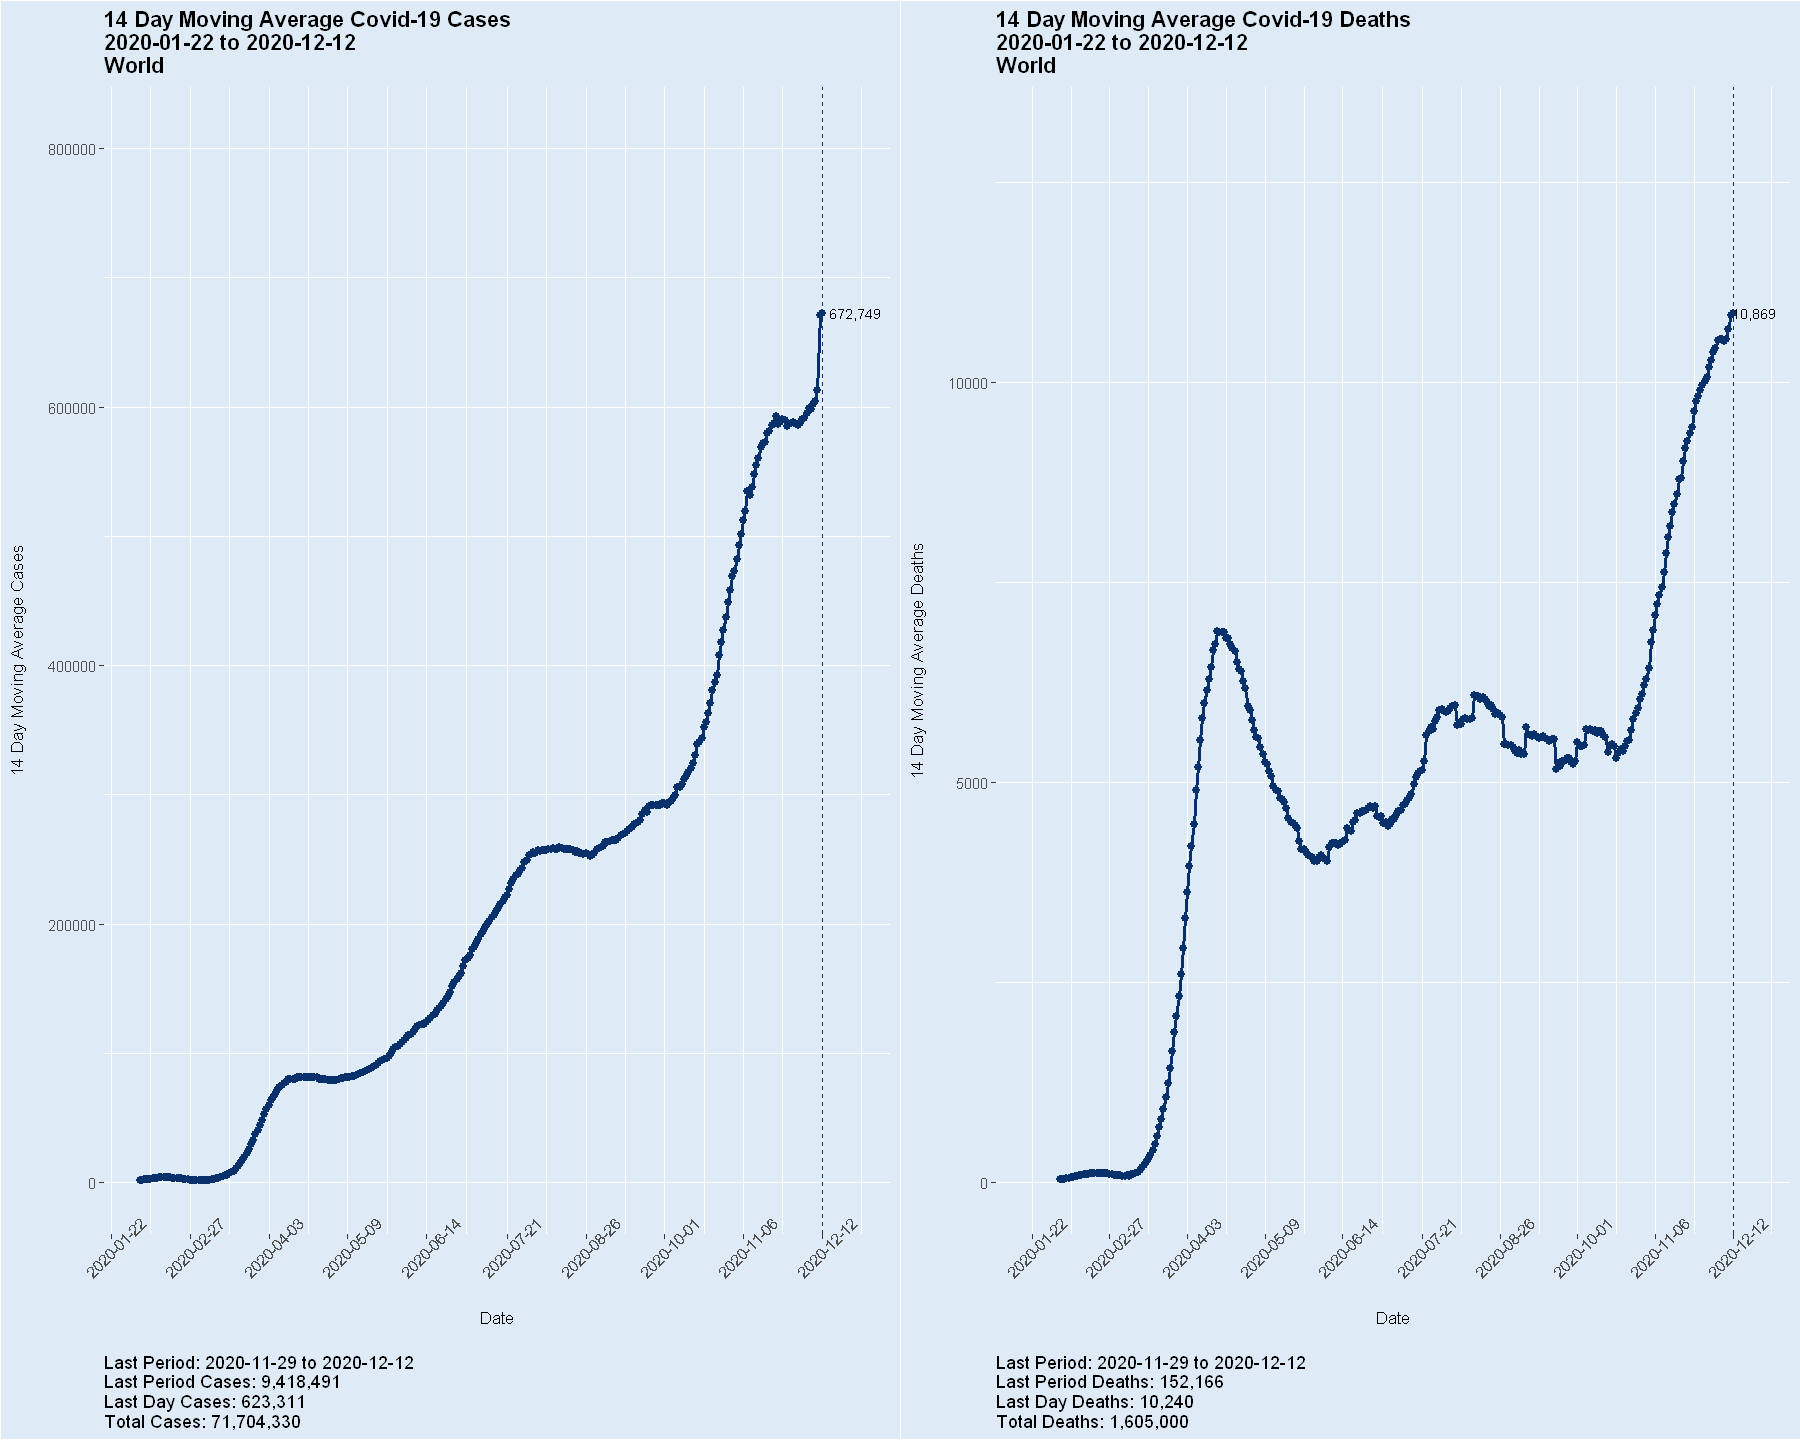

In [110]:

lab <- "World" 
lags <- 14

fname = paste0("ma-",lab,"-",lags,".jpg")

grphs <- mkgraph(mfinalworld,label=lab,lags=lags)
gp1 <- grphs[[1]]
gp2 <- grphs[[2]]

ggsave(fname, arrangeGrob(gp1,gp2,nrow=1),width=12,height=8)

options(repr.plot.width=15, repr.plot.height=12)

grid.arrange(gp1,gp2,nrow = 1, widths=c(2.5,2.5),clip=FALSE)


In [111]:
setkey(mfinalworld,countryregion,provincestate,date)


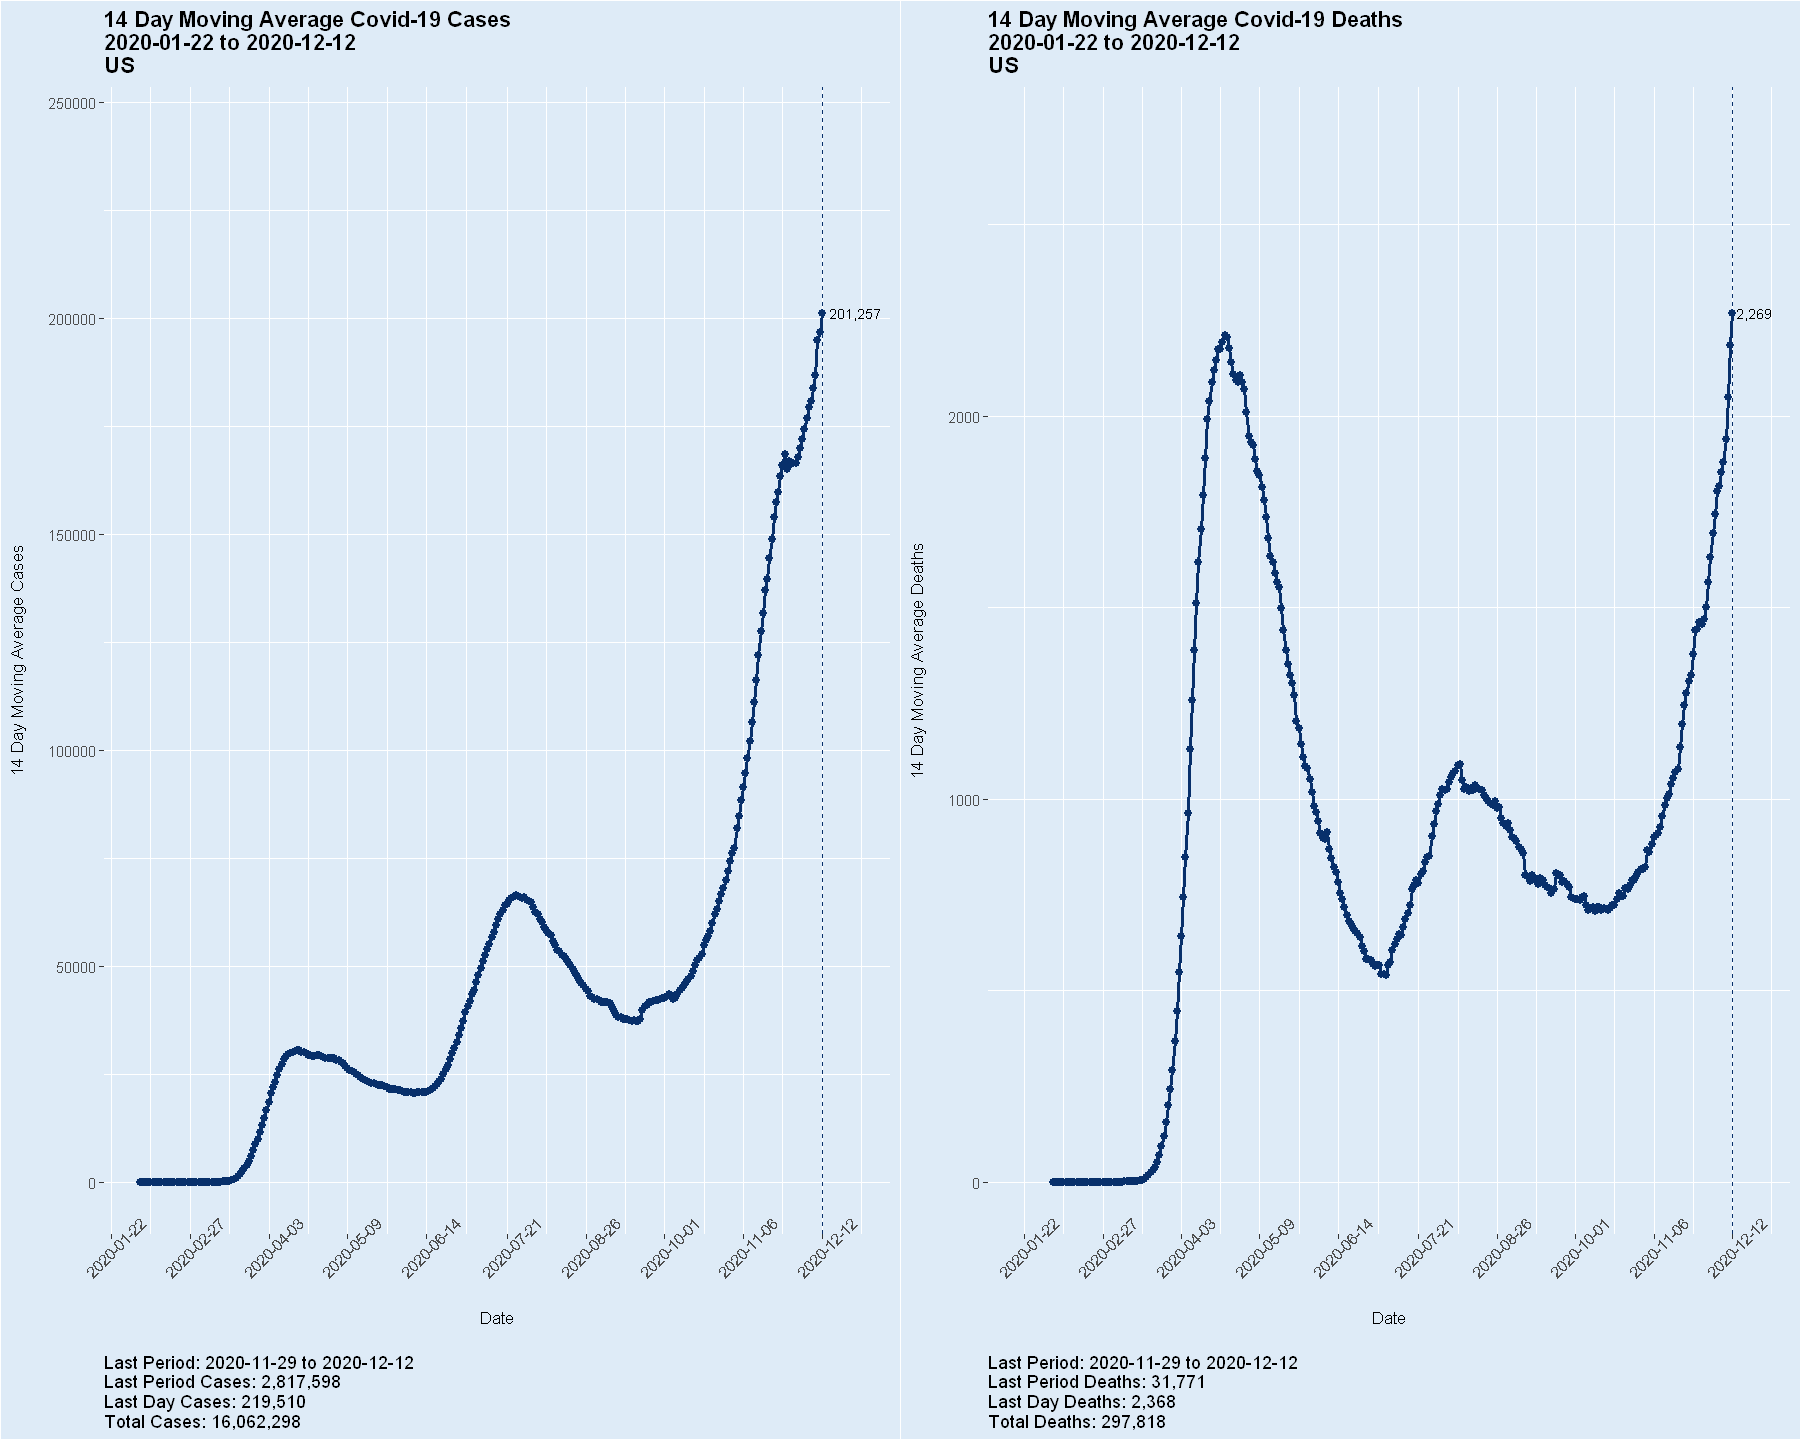

In [112]:

lab <- "US" 
lags <- 14

fname = paste0("ma-",lab,"-",lags,".jpg")

grphs <- mkgraph(mfinalworld[lab],label=lab,lags=lags)
gp1 <- grphs[[1]]
gp2 <- grphs[[2]]

ggsave(fname, arrangeGrob(gp1,gp2,nrow=1),width=12,height=8)

options(repr.plot.width=15, repr.plot.height=12)

grid.arrange(gp1,gp2,nrow = 1, widths=c(2.5,2.5),clip=FALSE)


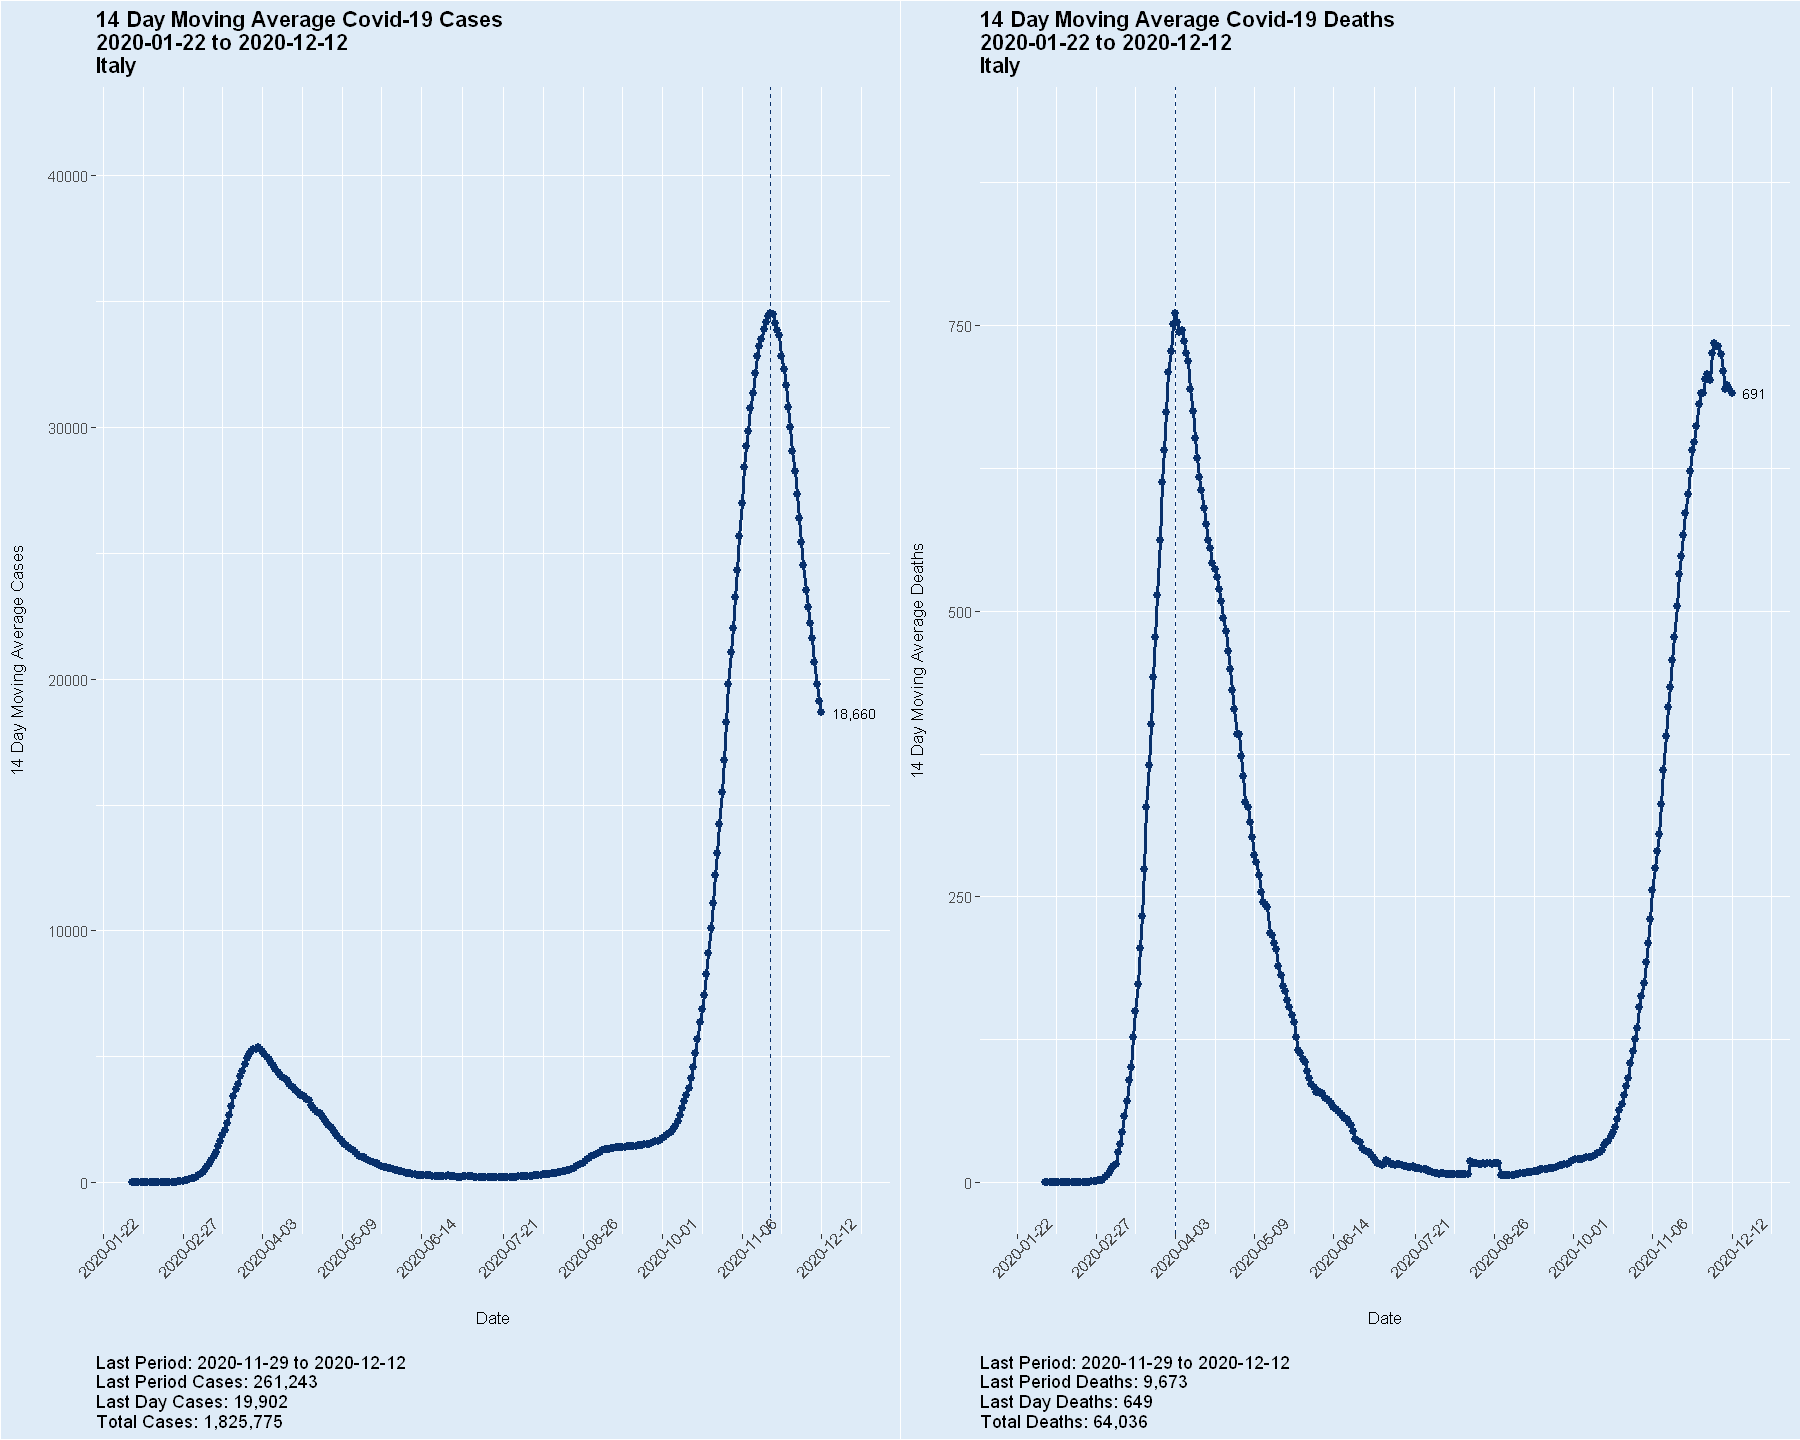

In [113]:

lab <- "Italy" 
lags <- 14

fname = paste0("ma-",lab,"-",lags,".jpg")

grphs <- mkgraph(mfinalworld[lab],label=lab,lags=lags)
gp1 <- grphs[[1]]
gp2 <- grphs[[2]]

ggsave(fname, arrangeGrob(gp1,gp2,nrow=1),width=12,height=8)

options(repr.plot.width=15, repr.plot.height=12)

grid.arrange(gp1,gp2,nrow = 1, widths=c(2.5,2.5),clip=FALSE)


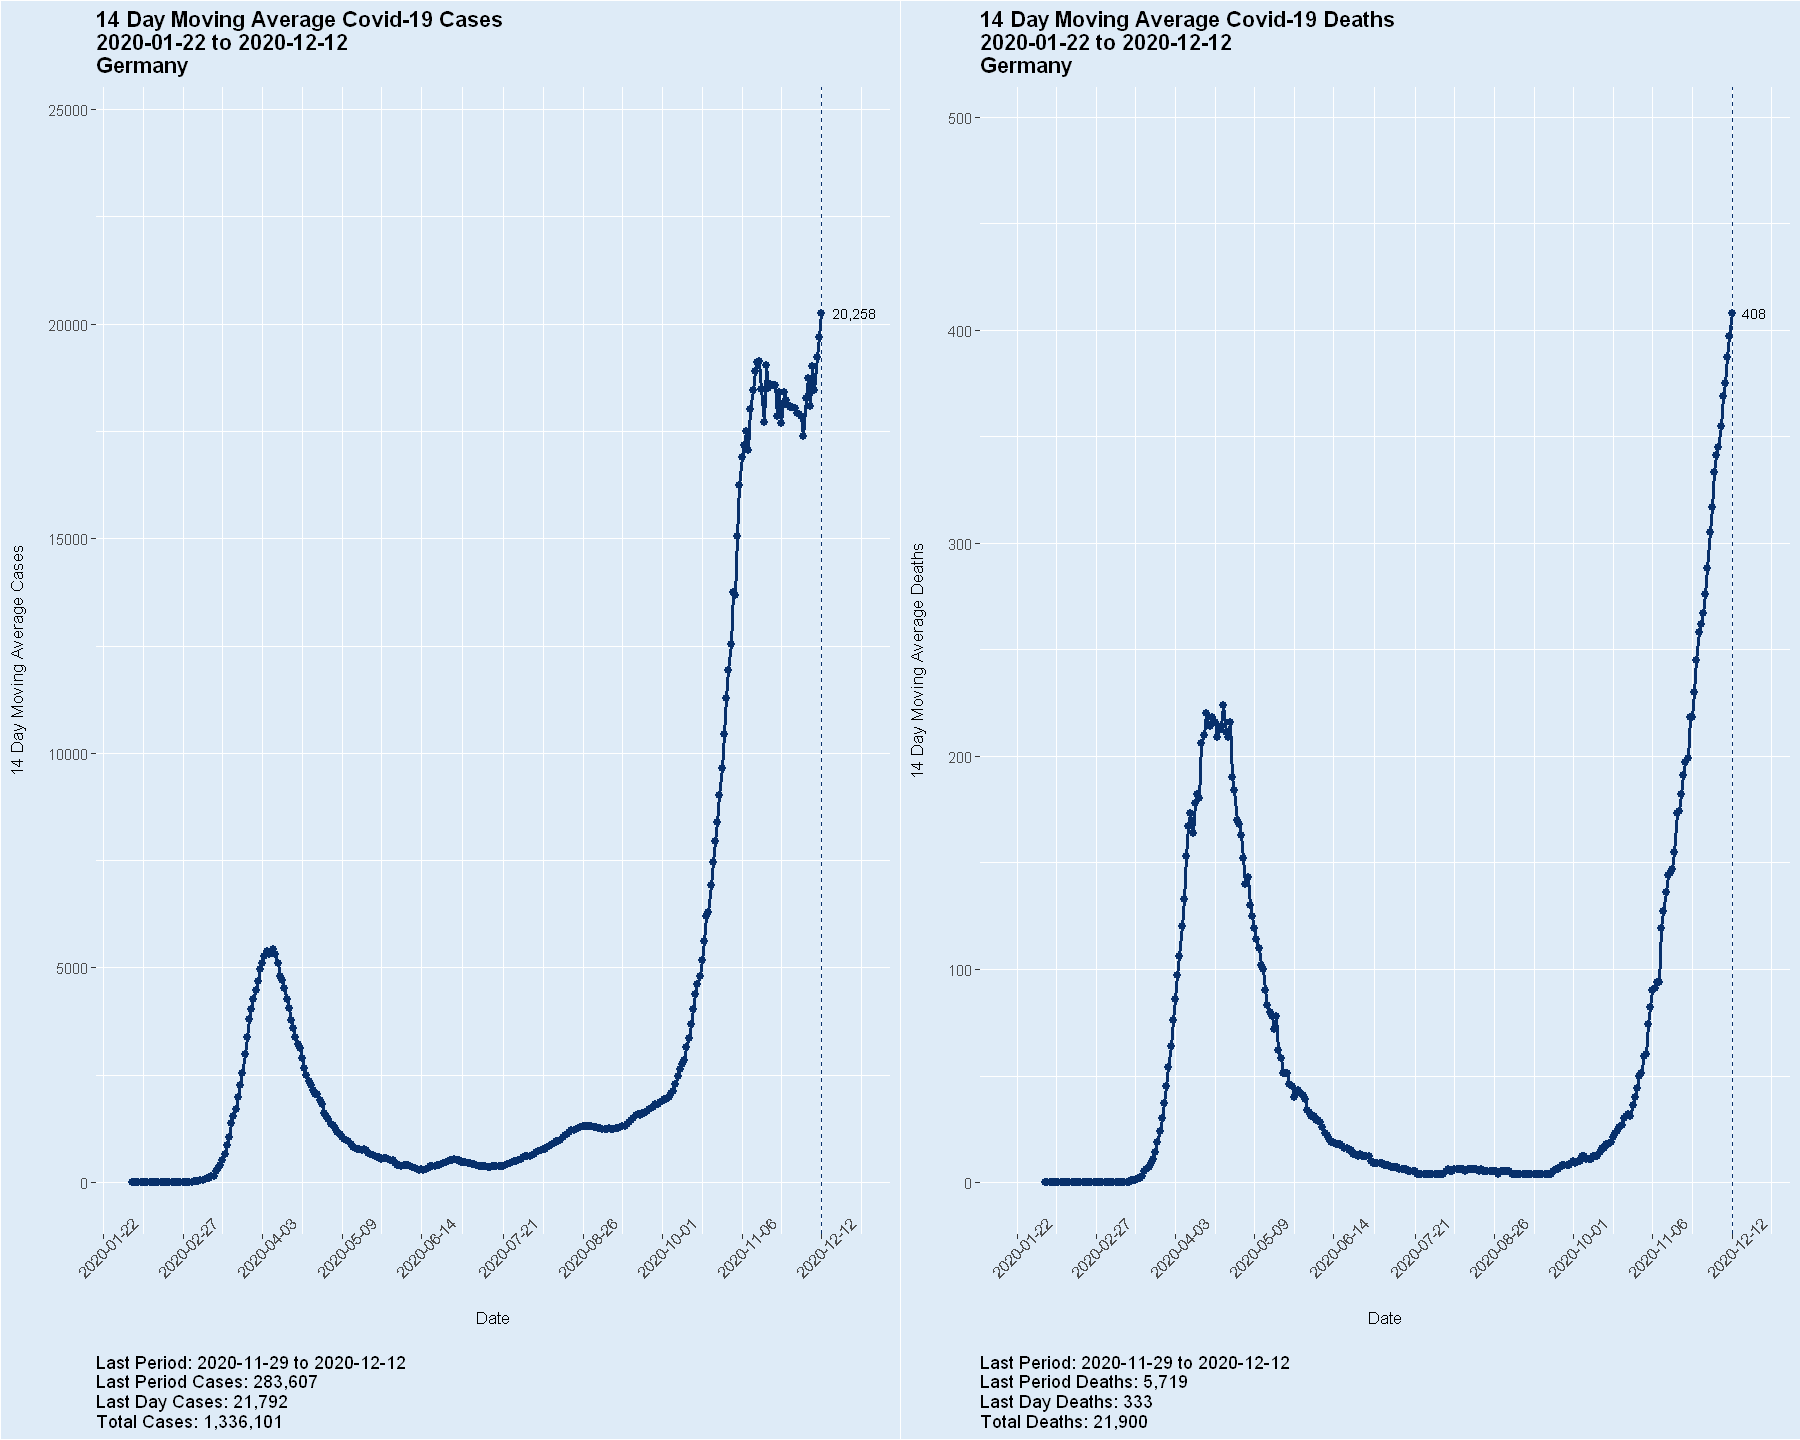

In [114]:

lab <- "Germany" 
lags <- 14

fname = paste0("ma-",lab,"-",lags,".jpg")

grphs <- mkgraph(mfinalworld[lab],label=lab,lags=lags)
gp1 <- grphs[[1]]
gp2 <- grphs[[2]]

ggsave(fname, arrangeGrob(gp1,gp2,nrow=1),width=12,height=8)

options(repr.plot.width=15, repr.plot.height=12)

grid.arrange(gp1,gp2,nrow = 1, widths=c(2.5,2.5),clip=FALSE)


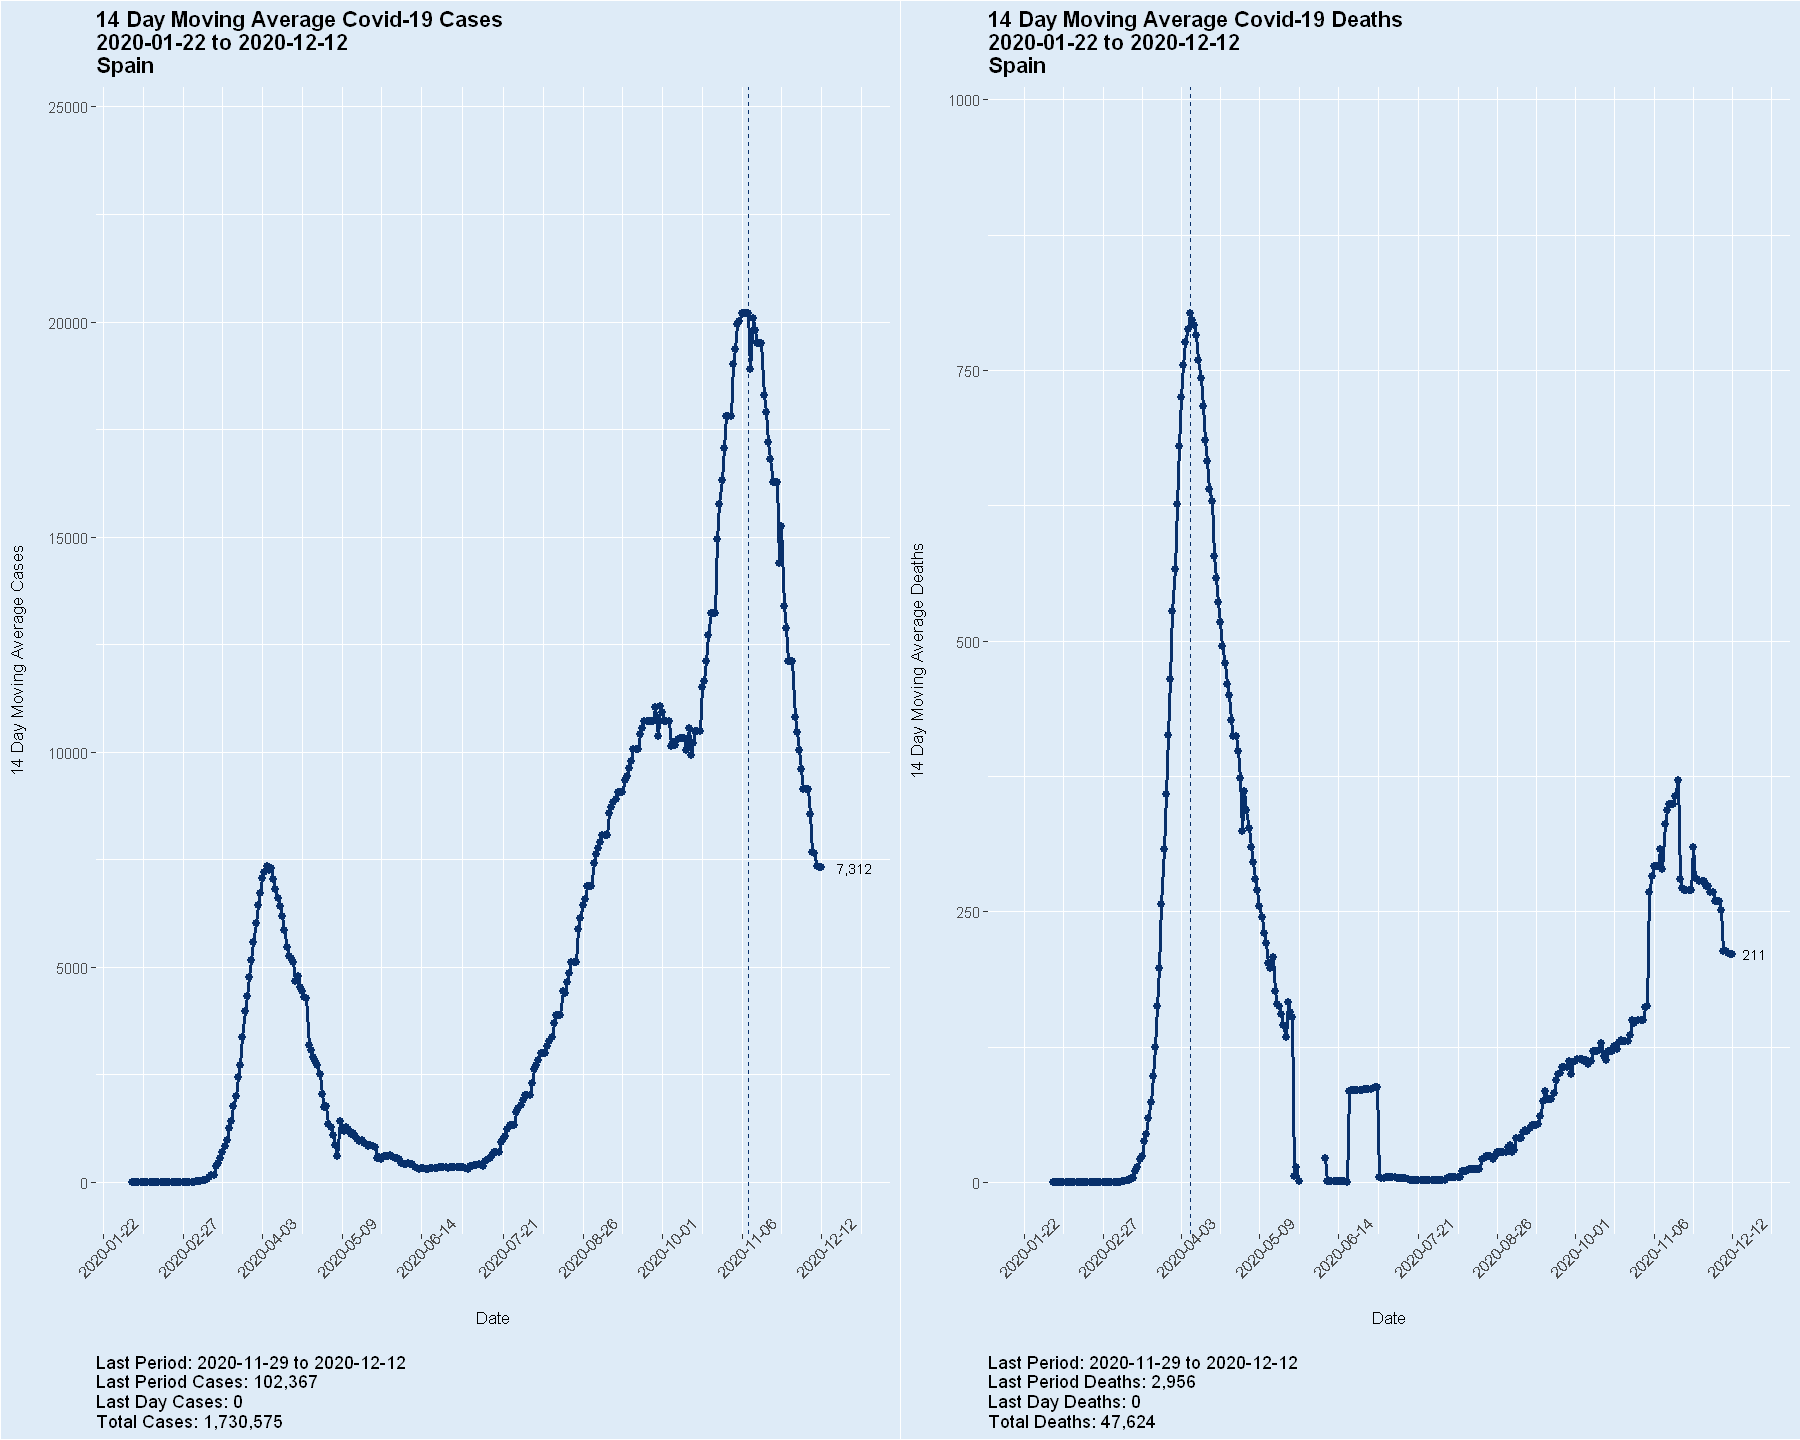

In [115]:

lab <- "Spain" 
lags <- 14

fname = paste0("ma-",lab,"-",lags,".jpg")

grphs <- mkgraph(mfinalworld[lab],label=lab,lags=lags)
gp1 <- grphs[[1]]
gp2 <- grphs[[2]]

ggsave(fname, arrangeGrob(gp1,gp2,nrow=1),width=12,height=8)

options(repr.plot.width=15, repr.plot.height=12)

grid.arrange(gp1,gp2,nrow = 1, widths=c(2.5,2.5),clip=FALSE)


In [116]:
inlist <- c(
"Afghanistan",                     
"Argentina",                       
"Armenia",                         
"Australia",                       
"Austria",                         
"Belarus",                         
"Belgium",                         
"Brazil",                          
"Cambodia",                        
"Canada",                          
"Chile",                           
"China",                           
"Colombia",                        
"Costa Rica",                     
"Croatia",                         
"Cuba",                            
"Denmark",                         
"Dominican Republic",              
"Egypt",                           
"Finland",                         
"France",                          
"Germany",                         
"Greece",                          
"Hungary",                         
"Iceland",                         
"India",                           
"Indonesia",                       
"Iran",                            
"Iraq",                            
"Ireland",                         
"Israel",                          
"Italy",                           
"Jamaica",                         
"Japan",                           
"Jordan",                          
"Korea, South",                    
"Laos",                            
"Latvia",                          
"Lithuania",                       
"Luxembourg",                      
"Mexico",                          
"Netherlands",                     
"New Zealand",                     
"Nicaragua",                       
"Norway",                          
"Pakistan",                        
"Panama",                          
"Paraguay",                        
"Peru",                            
"Philippines",                     
"Poland",                          
"Portugal",                        
"Romania",                         
"Russia",                          
"Saudi Arabia",                    
"Serbia",                          
"Singapore",                       
"Slovakia",                        
"Slovenia",                        
"South Africa",                    
"Spain",                           
"Sweden",                          
"Switzerlan",                     
"Syria",                           
"Taiwan",                         
"Thailand",                        
"Turkey",                          
"US",                              
"Ukraine",                         
"United Arab Emirates",            
"United Kingdom",                  
"Uruguay",                         
"Uzbekistan",                      
"Venezuela",                       
"Vietnam",                         
"West Bank and Gaza"
)              

In [117]:
tic()

lags <- 14

dowork <- function(lab) 
{

    fname = paste0("ma-",lab,"-",lags,".jpg")
    grphs <- mkgraph(mfinalworld[countryregion==lab],label=lab,lags=lags)
    gp1 <- grphs[[1]]
    gp2 <- grphs[[2]]

    ggsave(fname, arrangeGrob(gp1,gp2,nrow=1),width=12,height=8)

}

mfinalworld[is.element(countryregion,inlist),dowork(as.character(countryregion)),.(countryregion)]

toc()

blanks(2)

countryregion
<fct>


elapsed time is 31.830000 seconds 

 


In [118]:
lag <- 14
aggfinal <- mfinalworld[,.(cases=sumna(daycases),deaths=sumna(daydeaths)),.(date)][,`:=`(cumcases=cumsum(cases),cumdeaths=cumsum(deaths))]

setcolorder(aggfinal[,`:=`(casesms=frollsum(cases,lag,align="right"),deathsms=frollsum(deaths,lag,align="right"))][
    ,`:=`(cf=round(100*(deaths/cases),3),cfcum=round(100*(cumdeaths/cumcases),3),cfms=round(100*(deathsms/casesms),3),lag=lag,recnum=.I)],   
         c("recnum","lag","date","cases","cumcases","casesms","deaths","cumdeaths","deathsms","cf","cfcum","cfms"))
aggfinal[,`:=`('up?'=ifelse(diffna(cfms)>0,'+','-'))]

meta(aggfinal)

mykab(tail(aggfinal[date>="2020-03-01"],20))



|name    |class                 |rows|columns|size    |
|:-------|:---------------------|:---|:------|:-------|
|aggfinal|data.table, data.frame|326 |13     |29.56 KB|

Classes 'data.table' and 'data.frame':	326 obs. of  13 variables:
 $ recnum   : int  1 2 3 4 5 6 7 8 9 10 ...
 $ lag      : num  14 14 14 14 14 14 14 14 14 14 ...
 $ date     : Date, format: "2020-01-22" "2020-01-23" ...
 $ cases    : int  0 99 287 493 684 809 2651 589 2068 1692 ...
 $ cumcases : int  0 99 386 879 1563 2372 5023 5612 7680 9372 ...
 $ casesms  : num  NA NA NA NA NA NA NA NA NA NA ...
 $ deaths   : int  0 1 8 16 14 26 49 2 38 42 ...
 $ cumdeaths: int  0 1 9 25 39 65 114 116 154 196 ...
 $ deathsms : num  NA NA NA NA NA NA NA NA NA NA ...
 $ cf       : num  NaN 1.01 2.79 3.25 2.05 ...
 $ cfcum    : num  NaN 1.01 2.33 2.84 2.5 ...
 $ cfms     : num  NA NA NA NA NA NA NA NA NA NA ...
 $ up?      : chr  NA NA NA NA ...
 - attr(*, ".internal.selfref")=<externalptr> 
NULL




|recnum|lag|date      |cases  |cumcases|casesms|deaths|cumdeaths|deathsms|cf   |cfcum|cfms |up?|
|:-----|:--|:---------|:------|:-------|:------|:-----|:--------|:-------|:----|:----|:----|:--|
|307   |14 |2020-11-23|521699 |59212158|8235883|8314  |1396895  |132213  |1.594|2.359|1.605|+  |
|308   |14 |2020-11-24|588303 |59800461|8268046|12778 |1409673  |135008  |2.172|2.357|1.633|+  |
|309   |14 |2020-11-25|633045 |60433506|8255683|12057 |1421730  |136676  |1.905|2.353|1.656|+  |
|310   |14 |2020-11-26|581314 |61014820|8189661|10741 |1432471  |137632  |1.848|2.348|1.681|+  |
|311   |14 |2020-11-27|672318 |61687138|8212856|10621 |1443092  |138700  |1.580|2.339|1.689|+  |
|312   |14 |2020-11-28|598701 |62285839|8217620|9742  |1452834  |139450  |1.627|2.333|1.697|+  |
|313   |14 |2020-11-29|486678 |62772517|8230645|6919  |1459753  |140109  |1.422|2.325|1.702|+  |
|314   |14 |2020-11-30|505910 |63278427|8207492|8687  |1468440  |140941  |1.717|2.321|1.717|+  |
|315   |14 |2020-12-01|60495

In [119]:
mkcfdata <- function(dt=aggfinal)
{

        slug <- melt(dt, id.vars=c(2,3),measure.vars=c(10:12),variable.name="type",value.name="casefatality")
        slug[,`:=`(type=factor(type, levels=c("cf","cfms","cfcum"), labels=c("Daily CF",paste0(last(lag)," Day Rolling Sum CF"),"Cumulative CF")))]
}

work <- mkcfdata(aggfinal)

In [120]:
work[,.N,.(type)]


type,N
<fct>,<int>
Daily CF,326
Cumulative CF,326
14 Day Rolling Sum CF,326


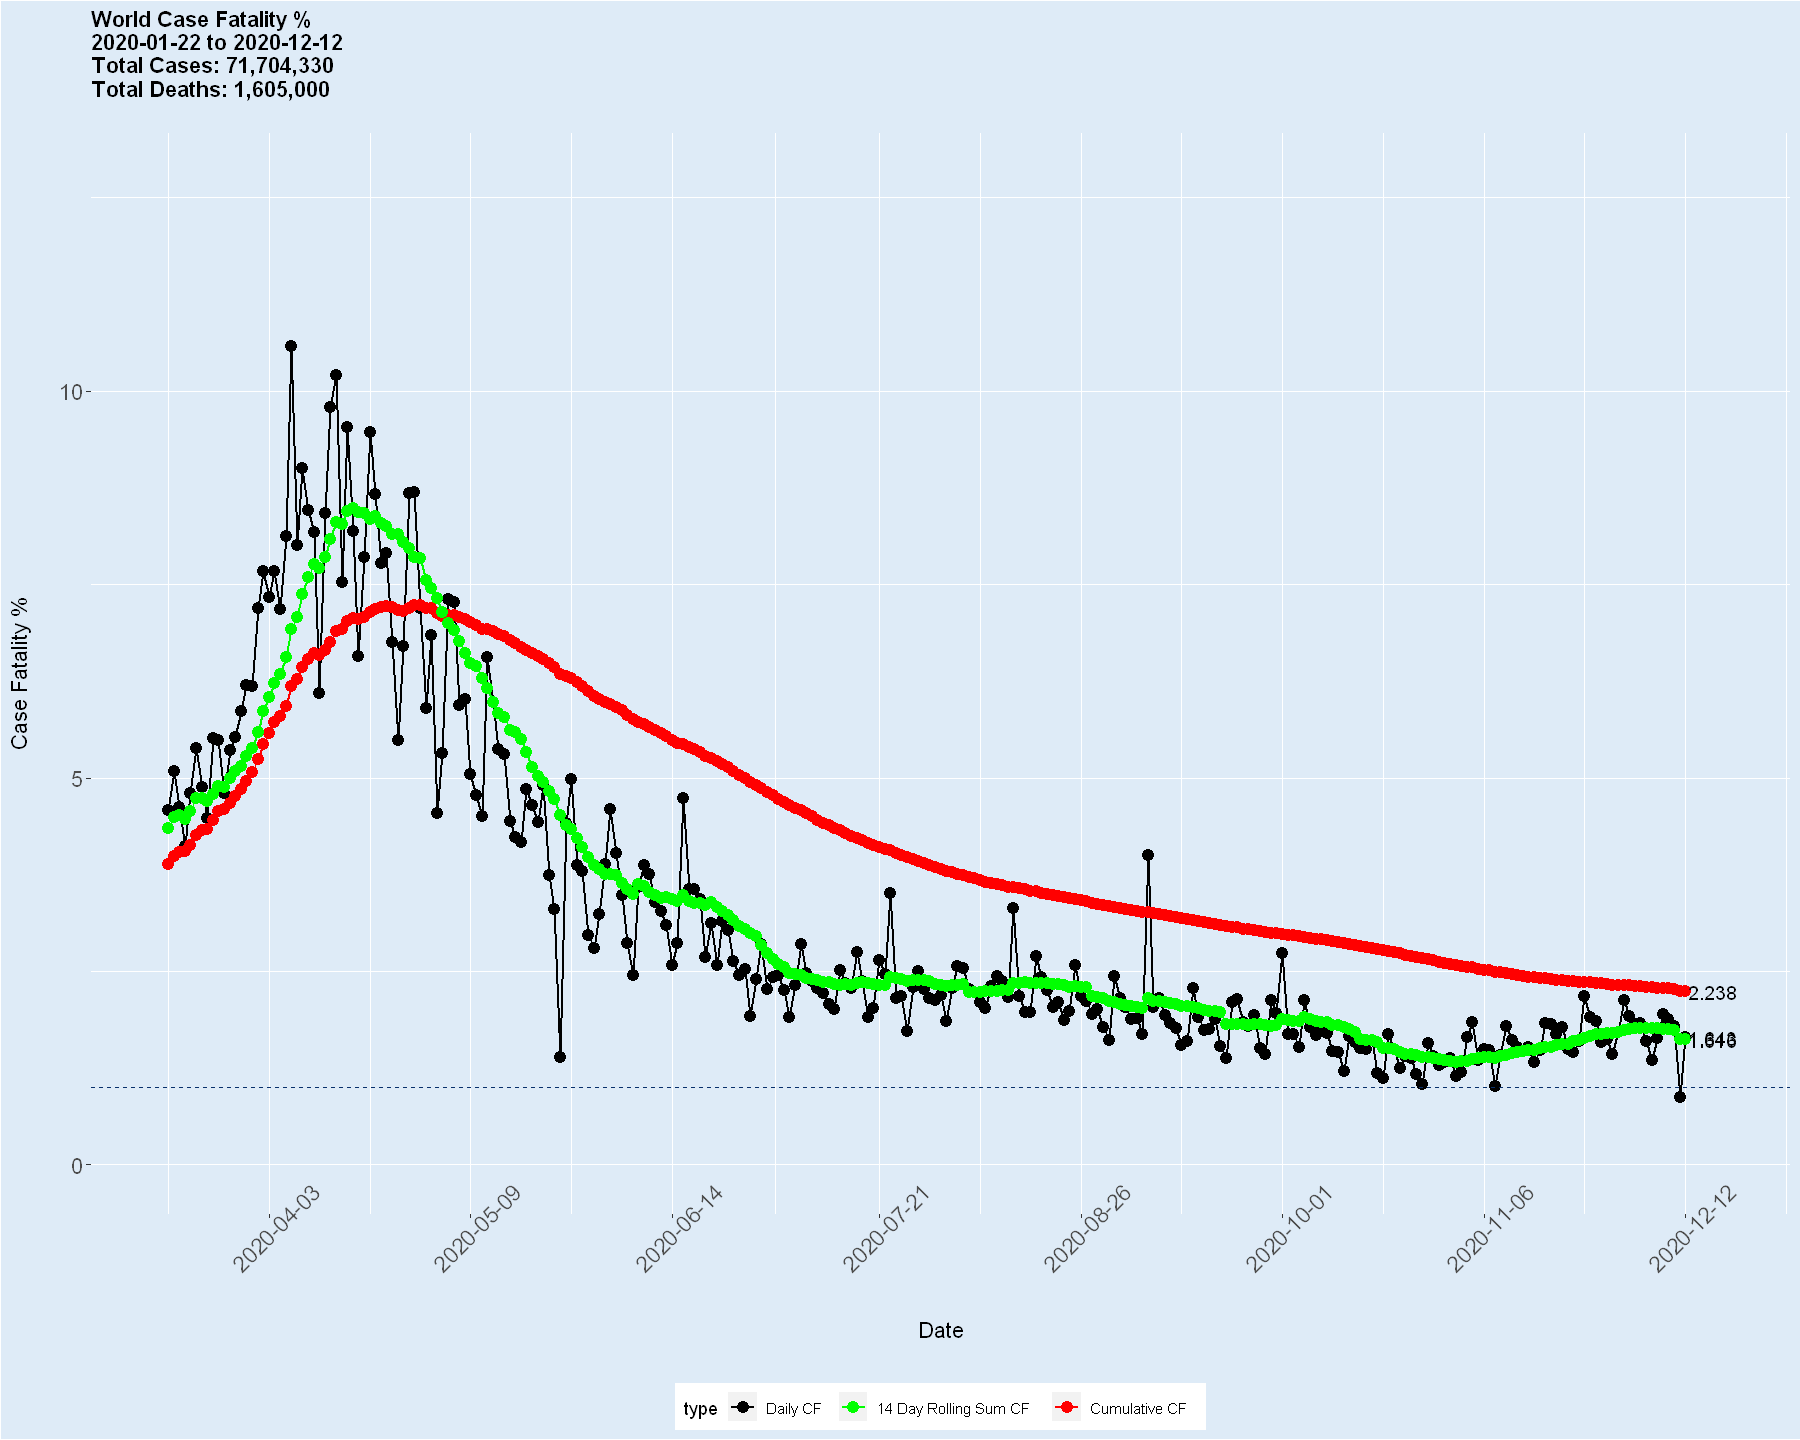

In [121]:
mx <- work[date>="2020-03-16",max(casefatality)]

udates <- unique(work$date)
ulen <- length(udates)
qtl <- round(quantile(1:ulen,probs=seq(0,1,1/9)))
grdates <- udates[qtl]

tit <- paste0("World Case Fatality %\n",aggfinal[,first(date)]," to ",aggfinal[,last(date)],
             "\nTotal Cases: ",format(aggfinal[.N]$cumcases,big.mark=","),
             "\nTotal Deaths: ",format(aggfinal[.N]$cumdeaths,big.mark=","),"\n")

foot <- paste0("Period: ",work[,first(date)], " to ",work[,last(date)],
              "\nTotal Deaths: ",work[,last(casefatality)])
anno0 <- work[type=="Daily CF"][.N]
anno1 <- work[type=="14 Day Rolling Sum CF"][.N]
anno2 <- work[type=="Cumulative CF"][.N]

pal <- brewer.pal(9,"Blues")

gp <- ggplot(work[date>="2020-03-16"],
      aes(x=date,y=casefatality,color=type)) +
     geom_line(size=.8) +
     geom_point(size=3) +
    geom_hline(aes(yintercept=1), na.rm = FALSE, show.legend = NA,col=pal[9],size=.3,linetype=2) +
    theme(plot.background = element_rect(fill = pal[2]), 
    panel.background = element_rect(fill = pal[2])) +
    theme(axis.title=element_text(size=13)) +
    theme(plot.title = element_text (face="bold",size=13)) +
    theme(axis.text = element_text(size=13)) +
    theme(axis.text.x = element_text(angle=45)) +

    scale_color_manual(breaks = c(levels(work$type)[1],
                                  levels(work$type)[2],
                                  levels(work$type)[3]),
                       values=c("black", "green", "red")) +

    scale_y_continuous(limits=c(0,1.2*mx)) +
    scale_x_date(breaks=grdates) +
    labs(title=tit,x="Date\n",y="Case Fatality %\n") + #,caption=foot) +
    theme(plot.caption = element_text(hjust = 0,size=10)) +
    theme(legend.position="bottom") +
    geom_text(data = anno0, aes(x = date+5,  y = casefatality, label = casefatality),col='black',size=4) +
    geom_text(data = anno1, aes(x = date+5,  y = casefatality, label = casefatality),col='black',size=4) +
    geom_text(data = anno2, aes(x = date+5,  y = casefatality, label = casefatality),col='black',size=4) 

print(gp)


In [122]:
wdir <- "/steve/covid/world"
setwd(wdir)

fname <- "casefatality.jpg"

jpeg(file=fname,width = 864, height = 720)
gp
dev.off()


png 
  2